# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#7b6b59;overflow:hidden">TRAIN MODEL SKLEARN</div>

Conda env: `artofproblemsolving`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter
import tensorflow as tf

# utils
from utils.utils_for_classification import load_text_dataset_from_directory
from utils.util import save_pkl
from utils.util import create_folder
from utils.util_write_training_result import append_training_result
from utils.util import map_str_label, map_int_label

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Model
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


def tf_loss(y_actual_list_int, y_pred_list_of_list_proba):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_actual_list_int, y_pred_list_of_list_proba))

def compare_actual_and_predict_values(model, trained_vectorizer, X, y_str, y_int, csv_file_name_path: str): 
    pred_result_int = model.predict(trained_vectorizer.transform(X))
    pred_result_str = [map_int_label[int(i)] for i in pred_result_int]
    
    df_ = pd.DataFrame({
        'text': X,
        'actual': y_str,
        'predicted': pred_result_str,
        'actual_int': y_int,
        'predicted_int': pred_result_int,
    })
    df_ = df_.sort_values(by=['actual'], ascending=True)
    df_.reset_index(inplace=True)

    display(df_.sample(10, random_state=42).sort_values(by=['actual'], ascending=True))
    df_.to_csv(csv_file_name_path, index=False)

def model_evaluate_and_analytics(model, trained_vectorizer, X, y_str, y_int, suptitle: str, cm_file_name_path: str, figsize=(16, 10)): 
    pred_proba_result = model.predict_proba(trained_vectorizer.transform(X))
    pred_result_int = model.predict(trained_vectorizer.transform(X))
    pred_result_str = [map_int_label[int(i)] for i in pred_result_int]
    
    loss = tf_loss(y_int, pred_proba_result)
    
    metricsstr_str = classification_report(y_str, pred_result_str, digits=4)
    metricsint_str = classification_report(y_int, pred_result_int, digits=4)
    
    metrics_dict = classification_report(y_str, pred_result_str, output_dict=True)
    metrics_dict['loss'] = loss
    
    # Plot & save
    class_names_str = ['Algebra', 'Combinatorics', 'Geometry', 'Number Theory']
    class_names_int = [0, 1, 2, 3]
    cm_str = confusion_matrix(y_str, pred_result_str, labels=class_names_str)
    cm_int = confusion_matrix(y_int, pred_result_int, labels=class_names_int)

    figure, ax = plt.subplots(2, 2, figsize=figsize, layout="constrained")
    figure.suptitle(suptitle)

    disp_str = ConfusionMatrixDisplay(confusion_matrix=cm_str, display_labels=class_names_str)
    disp_str.plot(ax=ax[0, 0], cmap='Greens')
    ax[0, 0].set_title('String Labels')

    disp_int = ConfusionMatrixDisplay(confusion_matrix=cm_int, display_labels=class_names_int)
    disp_int.plot(ax=ax[0, 1], cmap='Blues')
    ax[0, 1].set_title('Integer Labels')

    figure.text(0.5, 0.16, metricsstr_str, fontsize=16, ha="right", fontname="Consolas")
    figure.text(0.98, 0.16, metricsint_str, fontsize=16, ha="right", fontname="Consolas")

    figure.text(0.54, 0.12, f"loss: {loss:.4f}", fontsize=16, ha="center", fontname="Consolas")

    figure.delaxes(ax[1, 0])
    figure.delaxes(ax[1, 1])

    plt.savefig(cm_file_name_path)
    plt.show()
    
    return metrics_dict
    
def super_complete_compile_sklearn_model(idnote, sklearn_model, trained_vectorizer, X_train, y_train_str, y_train_int, X_test, y_test_str, y_test_int):
    if type(sklearn_model) == MultinomialNB:
        model_name = "MultinomialNB"
        if type(trained_vectorizer) == TfidfVectorizer: model_name+= "_TFIDF"
        if type(trained_vectorizer) == CountVectorizer: model_name+= "_COUNT"
        
        model = MultinomialNB()
        start = perf_counter()
        model.fit(trained_vectorizer.transform(X_train), y_train_int)
        training_time = perf_counter() - start
        
        test_result = model_evaluate_and_analytics(
            model=model, 
            trained_vectorizer=trained_vectorizer, 
            X=X_test, 
            y_str=y_test_str,
            y_int=y_test_int, 
            suptitle=f"{model_name} | Confusion Matrix Data `test`", 
            cm_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_cmplot_test.jpg", 
            figsize=(16, 10)
            )
        compare_actual_and_predict_values(model, trained_vectorizer, X_test, y_test_str, y_test_int, csv_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_test.csv")
        
        test_result['training_time'] = training_time
        train_result = model_evaluate_and_analytics(
            model=model, 
            trained_vectorizer=trained_vectorizer, 
            X=X_train, 
            y_str=y_train_str,
            y_int=y_train_int, 
            suptitle=f"{model_name} | Confusion Matrix Data `train`", 
            cm_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_cmplot_train.jpg", 
            figsize=(16, 10)
            )
        train_result['training_time'] = training_time
        compare_actual_and_predict_values(model, trained_vectorizer, X_train, y_train_str, y_train_int, csv_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_train.csv")
        
        return model, test_result, train_result
        
    if type(sklearn_model) == SVC:
        model_name = "SVC"
        if type(trained_vectorizer) == TfidfVectorizer: model_name+= "_TFIDF"
        if type(trained_vectorizer) == CountVectorizer: model_name+= "_COUNT"
        
        model = SVC(kernel='linear', C=1.0, probability=True)
        start = perf_counter()
        model.fit(trained_vectorizer.transform(X_train), y_train_int)
        training_time = perf_counter() - start
        
        test_result = model_evaluate_and_analytics(
            model=model, 
            trained_vectorizer=trained_vectorizer, 
            X=X_test, 
            y_str=y_test_str,
            y_int=y_test_int, 
            suptitle=f"{model_name} | Confusion Matrix Data `test`", 
            cm_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_cmplot_test.jpg", 
            figsize=(16, 10)
            )
        compare_actual_and_predict_values(model, trained_vectorizer, X_test, y_test_str, y_test_int, csv_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_test.csv")
        
        test_result['training_time'] = training_time
        train_result = model_evaluate_and_analytics(
            model=model, 
            trained_vectorizer=trained_vectorizer, 
            X=X_train, 
            y_str=y_train_str,
            y_int=y_train_int, 
            suptitle=f"{model_name} | Confusion Matrix Data `train`", 
            cm_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_cmplot_train.jpg", 
            figsize=(16, 10)
            )
        train_result['training_time'] = training_time
        compare_actual_and_predict_values(model, trained_vectorizer, X_train, y_train_str, y_train_int, csv_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_train.csv")
        
        return model, test_result, train_result
        
    if type(sklearn_model) == RandomForestClassifier:
        model_name = "RandomForestClassifier"
        if type(trained_vectorizer) == TfidfVectorizer: model_name+= "_TFIDF"
        if type(trained_vectorizer) == CountVectorizer: model_name+= "_COUNT"
        
        model = RandomForestClassifier(n_estimators=128*2, random_state=42)
        start = perf_counter()
        model.fit(trained_vectorizer.transform(X_train), y_train_int)
        training_time = perf_counter() - start
        
        test_result = model_evaluate_and_analytics(
            model=model, 
            trained_vectorizer=trained_vectorizer, 
            X=X_test, 
            y_str=y_test_str,
            y_int=y_test_int, 
            suptitle=f"{model_name} | Confusion Matrix Data `test`", 
            cm_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_cmplot_test.jpg", 
            figsize=(16, 10)
            )
        compare_actual_and_predict_values(model, trained_vectorizer, X_test, y_test_str, y_test_int, csv_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_test.csv")
        
        test_result['training_time'] = training_time
        train_result = model_evaluate_and_analytics(
            model=model, 
            trained_vectorizer=trained_vectorizer, 
            X=X_train, 
            y_str=y_train_str,
            y_int=y_train_int, 
            suptitle=f"{model_name} | Confusion Matrix Data `train`", 
            cm_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_cmplot_train.jpg", 
            figsize=(16, 10)
            )
        train_result['training_time'] = training_time
        compare_actual_and_predict_values(model, trained_vectorizer, X_train, y_train_str, y_train_int, csv_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_train.csv")
        
        return model, test_result, train_result
        
    if type(sklearn_model) == KNeighborsClassifier:
        model_name = "KNeighborsClassifier"
        if type(trained_vectorizer) == TfidfVectorizer: model_name+= "_TFIDF"
        if type(trained_vectorizer) == CountVectorizer: model_name+= "_COUNT"
        
        model = KNeighborsClassifier(n_neighbors=8*2)
        start = perf_counter()
        model.fit(trained_vectorizer.transform(X_train), y_train_int)
        training_time = perf_counter() - start
        
        test_result = model_evaluate_and_analytics(
            model=model, 
            trained_vectorizer=trained_vectorizer, 
            X=X_test, 
            y_str=y_test_str,
            y_int=y_test_int, 
            suptitle=f"{model_name} | Confusion Matrix Data `test`", 
            cm_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_cmplot_test.jpg", 
            figsize=(16, 10)
            )
        compare_actual_and_predict_values(model, trained_vectorizer, X_test, y_test_str, y_test_int, csv_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_test.csv")
        
        test_result['training_time'] = training_time
        train_result = model_evaluate_and_analytics(
            model=model, 
            trained_vectorizer=trained_vectorizer, 
            X=X_train, 
            y_str=y_train_str,
            y_int=y_train_int, 
            suptitle=f"{model_name} | Confusion Matrix Data `train`", 
            cm_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_cmplot_train.jpg", 
            figsize=(16, 10)
            )
        train_result['training_time'] = training_time
        compare_actual_and_predict_values(model, trained_vectorizer, X_train, y_train_str, y_train_int, csv_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_train.csv")
        
        return model, test_result, train_result
        
    if type(sklearn_model) == LogisticRegression:
        model_name = "LogisticRegression"
        if type(trained_vectorizer) == TfidfVectorizer: model_name+= "_TFIDF"
        if type(trained_vectorizer) == CountVectorizer: model_name+= "_COUNT"
        
        model = LogisticRegression(max_iter=1024)
        start = perf_counter()
        model.fit(trained_vectorizer.transform(X_train), y_train_int)
        training_time = perf_counter() - start
        
        test_result = model_evaluate_and_analytics(
            model=model, 
            trained_vectorizer=trained_vectorizer, 
            X=X_test, 
            y_str=y_test_str,
            y_int=y_test_int, 
            suptitle=f"{model_name} | Confusion Matrix Data `test`", 
            cm_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_cmplot_test.jpg", 
            figsize=(16, 10)
            )
        compare_actual_and_predict_values(model, trained_vectorizer, X_test, y_test_str, y_test_int, csv_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_test.csv")
        
        test_result['training_time'] = training_time
        train_result = model_evaluate_and_analytics(
            model=model, 
            trained_vectorizer=trained_vectorizer, 
            X=X_train, 
            y_str=y_train_str,
            y_int=y_train_int, 
            suptitle=f"{model_name} | Confusion Matrix Data `train`", 
            cm_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_cmplot_train.jpg", 
            figsize=(16, 10)
            )
        train_result['training_time'] = training_time
        compare_actual_and_predict_values(model, trained_vectorizer, X_train, y_train_str, y_train_int, csv_file_name_path=f"saved_plots/classification/{idnote}_{model_name}_train.csv")
        
        return model, test_result, train_result



Load & prepare dataset

In [2]:
train_texts, train_str_labels = load_text_dataset_from_directory(r"..\data\classification\train")
train_int_labels = [map_str_label[label] for label in train_str_labels]

test_texts, test_str_labels = load_text_dataset_from_directory(r"..\data\classification\test")
test_int_labels = [map_str_label[label] for label in test_str_labels]

# Preprocess text data (Representation text to numeric)
TFIDF_vectorizer = TfidfVectorizer(lowercase=False)
vectorized_TFIDFtrain_texts = TFIDF_vectorizer.fit_transform(train_texts)

COUNT_vectorizer = CountVectorizer(lowercase=False)
vectorized_trainCOUNT_texts = COUNT_vectorizer.fit_transform(train_texts)


Found 4 labels in "..\data\classification\train"
 - Label "Algebra" 716 files
 - Label "Combinatorics" 658 files
 - Label "Geometry" 802 files
 - Label "Number Theory" 702 files
Total 2878 files
Found 4 labels in "..\data\classification\test"
 - Label "Algebra" 199 files
 - Label "Combinatorics" 183 files
 - Label "Geometry" 223 files
 - Label "Number Theory" 195 files
Total 800 files


### MultinomialNB

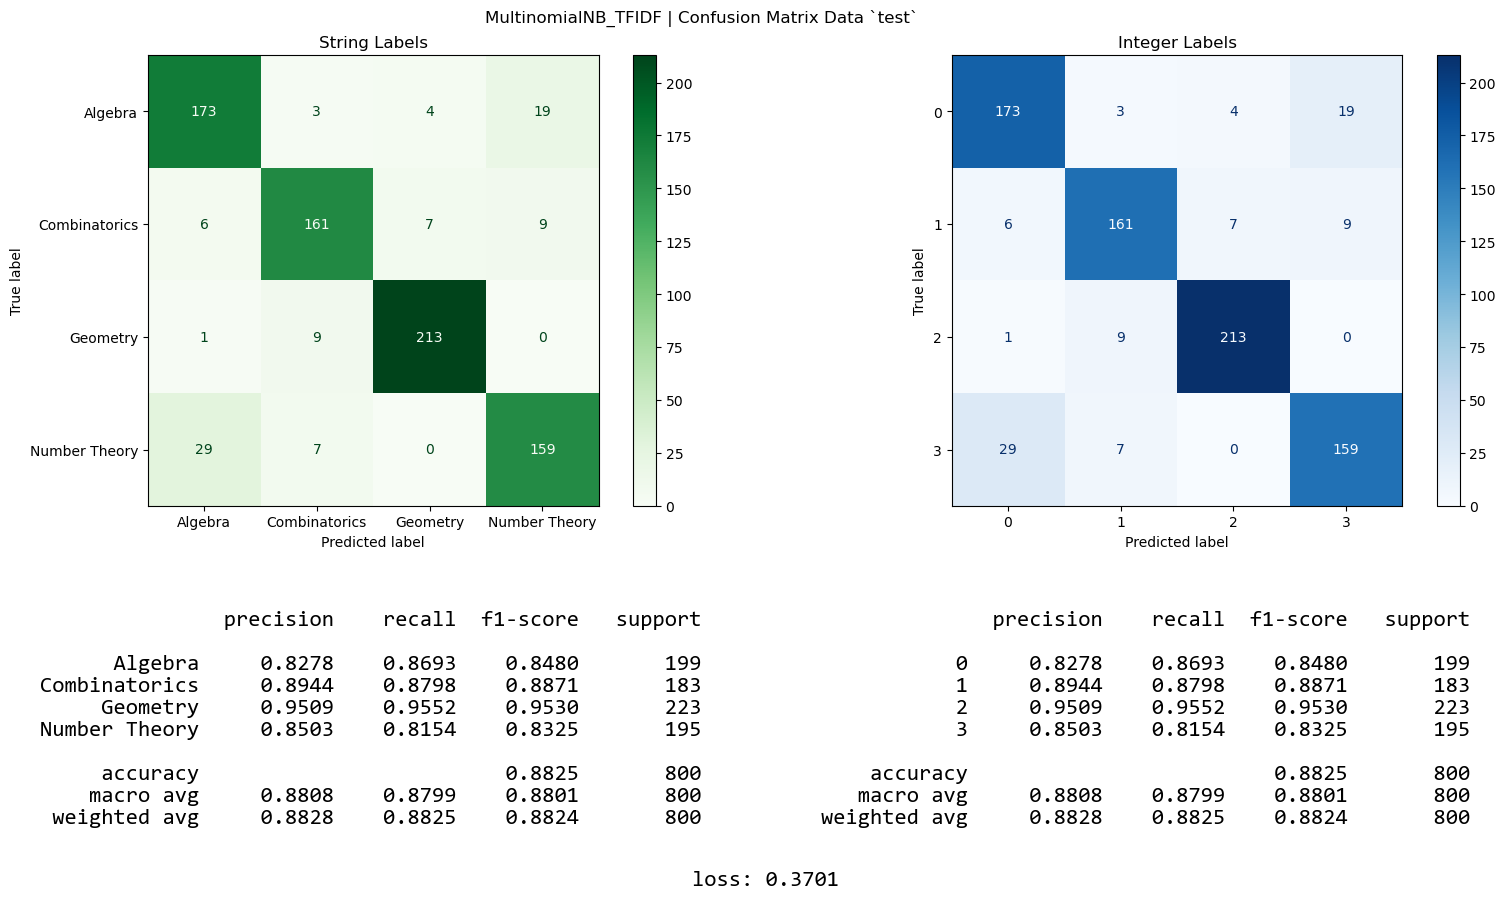

,index,text,actual,predicted,actual_int,predicted_int
63,190,Find all functions f: mathbb{R} rightarrow mat...,Algebra,Algebra,0,0
66,193,"Found all functions f: mathbb{R} to mathbb{R},...",Algebra,Algebra,0,0
346,277,A 9 times 12 rectangle is partitioned into uni...,Combinatorics,Combinatorics,1,1
533,392,A circle is called a separator for a set of fi...,Geometry,Geometry,2,2
490,576,"Let O, I, and omega be the circumcenter, the i...",Geometry,Geometry,2,2
456,600,Let P be a convex polygon. Prove that there ex...,Geometry,Geometry,2,2
696,771,"Find all pairs of positive integers (s, t), so...",Number Theory,Number Theory,3,3
667,792,Let left { {{a}_{n}} right }_{n geq 1} and lef...,Number Theory,Number Theory,3,3
621,745,Find all prime numbers p such that (x + y)^{19...,Number Theory,Number Theory,3,3
760,687,"Let (x_n), n=1,2, ldots be a sequence defined ...",Number Theory,Algebra,3,0


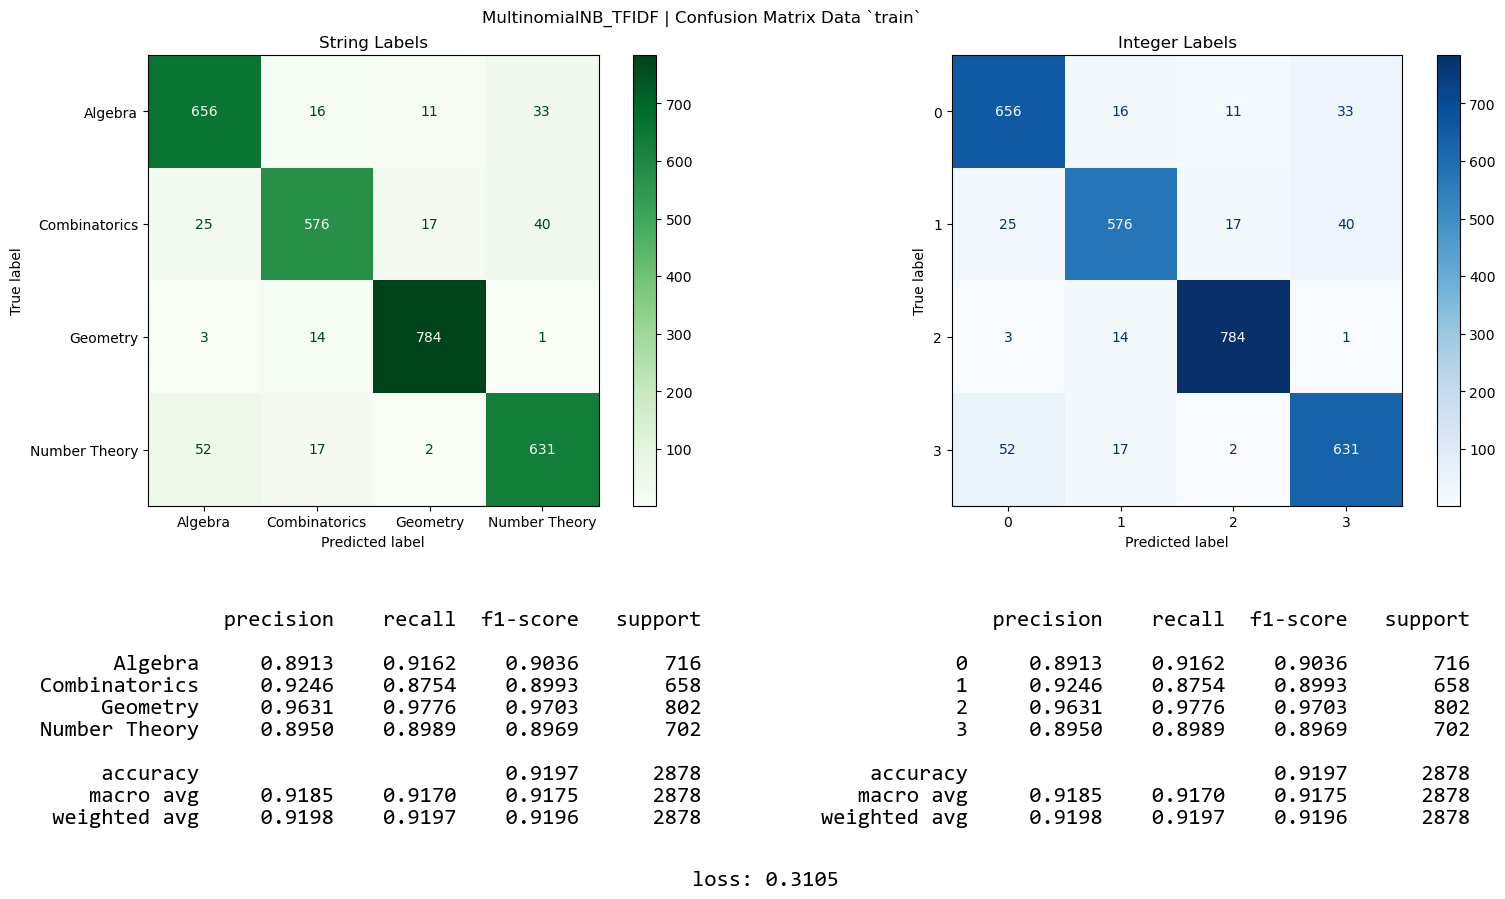

,index,text,actual,predicted,actual_int,predicted_int
471,20,"Prove that for all positive real numbers a,b,c...",Algebra,Algebra,0,0
1094,867,"Let E = {1, 2, dots , 16 } and let M be the co...",Combinatorics,Combinatorics,1,1
1255,1029,Two squares on an 8 times 8 chessboard are cal...,Combinatorics,Combinatorics,1,1
1128,795,"Let n geq 2, n in mathbb{N} and A_0 = (a_{01},...",Combinatorics,Algebra,1,0
945,1339,"On the board are written 2 , 3 , 5 ,... , 2003...",Combinatorics,Combinatorics,1,1
1453,1932,In a right-angled triangle ABC ( angle A = 90^...,Geometry,Geometry,2,2
1601,2080,Let ABCD be a rectangle of sides AB = 4 and BC...,Geometry,Geometry,2,2
1800,1499,Let ABC be an arbitrary triangle and M a point...,Geometry,Geometry,2,2
2376,2794,Find all functions g: mathbb{N} rightarrow mat...,Number Theory,Algebra,3,0
2251,2671,"Let nu be an irrational positive number, and l...",Number Theory,Number Theory,3,3


Already exist --> 'saved_models/classification/MultinomialNB_TFIDF' NOT CREATED
Saved: "saved_models/classification/MultinomialNB_TFIDF/model.pkl"
Saved: "saved_models/classification/MultinomialNB_TFIDF/vectorizer.pkl"


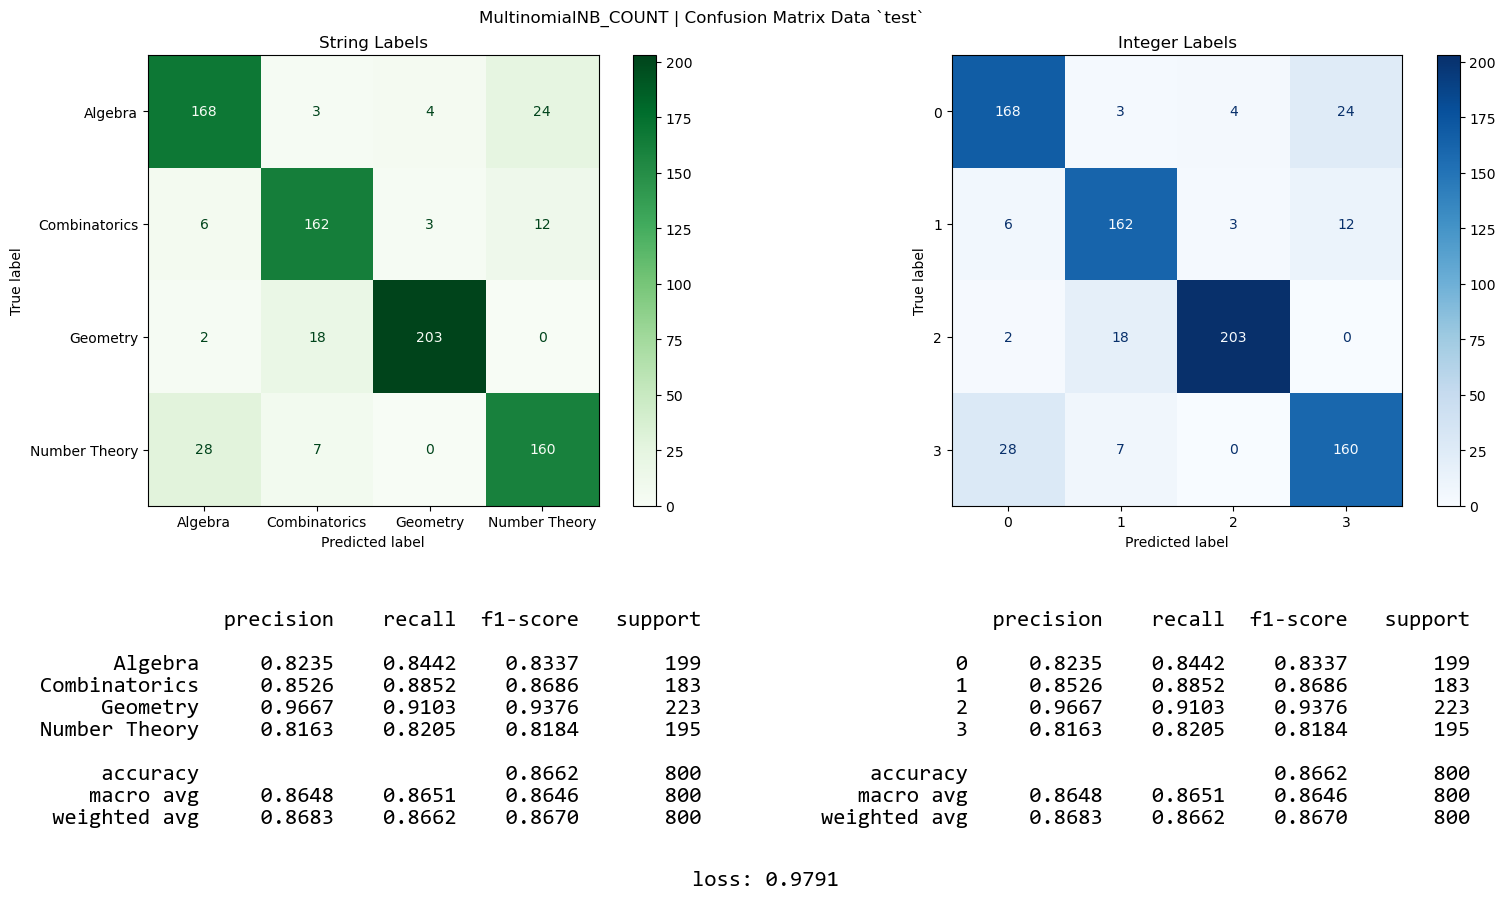

,index,text,actual,predicted,actual_int,predicted_int
63,190,Find all functions f: mathbb{R} rightarrow mat...,Algebra,Algebra,0,0
66,193,"Found all functions f: mathbb{R} to mathbb{R},...",Algebra,Algebra,0,0
346,277,A 9 times 12 rectangle is partitioned into uni...,Combinatorics,Combinatorics,1,1
533,392,A circle is called a separator for a set of fi...,Geometry,Combinatorics,2,1
490,576,"Let O, I, and omega be the circumcenter, the i...",Geometry,Geometry,2,2
456,600,Let P be a convex polygon. Prove that there ex...,Geometry,Geometry,2,2
696,771,"Find all pairs of positive integers (s, t), so...",Number Theory,Number Theory,3,3
667,792,Let left { {{a}_{n}} right }_{n geq 1} and lef...,Number Theory,Number Theory,3,3
621,745,Find all prime numbers p such that (x + y)^{19...,Number Theory,Number Theory,3,3
760,687,"Let (x_n), n=1,2, ldots be a sequence defined ...",Number Theory,Algebra,3,0


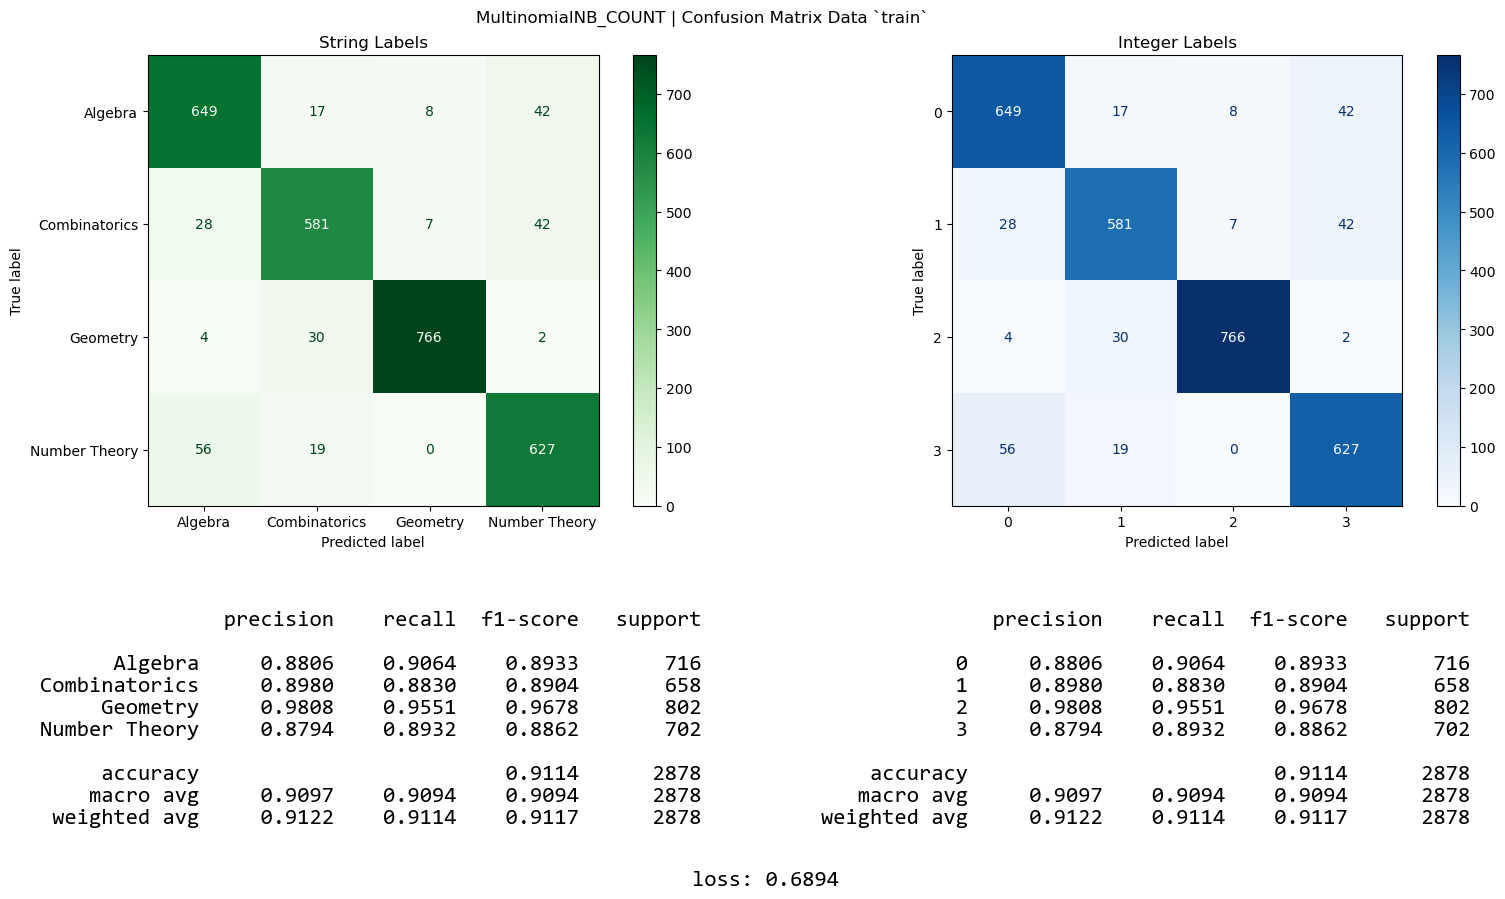

,index,text,actual,predicted,actual_int,predicted_int
471,20,"Prove that for all positive real numbers a,b,c...",Algebra,Algebra,0,0
1094,867,"Let E = {1, 2, dots , 16 } and let M be the co...",Combinatorics,Combinatorics,1,1
1255,1029,Two squares on an 8 times 8 chessboard are cal...,Combinatorics,Combinatorics,1,1
1128,795,"Let n geq 2, n in mathbb{N} and A_0 = (a_{01},...",Combinatorics,Algebra,1,0
945,1339,"On the board are written 2 , 3 , 5 ,... , 2003...",Combinatorics,Combinatorics,1,1
1453,1932,In a right-angled triangle ABC ( angle A = 90^...,Geometry,Geometry,2,2
1601,2080,Let ABCD be a rectangle of sides AB = 4 and BC...,Geometry,Geometry,2,2
1800,1499,Let ABC be an arbitrary triangle and M a point...,Geometry,Geometry,2,2
2376,2794,Find all functions g: mathbb{N} rightarrow mat...,Number Theory,Algebra,3,0
2251,2671,"Let nu be an irrational positive number, and l...",Number Theory,Number Theory,3,3


Already exist --> 'saved_models/classification/MultinomialNB_COUNT' NOT CREATED
Saved: "saved_models/classification/MultinomialNB_COUNT/model.pkl"
Saved: "saved_models/classification/MultinomialNB_COUNT/vectorizer.pkl"


In [3]:
model = MultinomialNB()
md_name = "MultinomialNB"

# TFIDF
id_note = "09"
model, tfidf_test_result, _ = super_complete_compile_sklearn_model(id_note, model, TFIDF_vectorizer, train_texts, train_str_labels, train_int_labels, test_texts, test_str_labels, test_int_labels)
temp = f"{id_note},classification,{md_name},TfidfVectorizer,-,-,-,-,-,{tfidf_test_result['training_time']:.2f},"
temp+= f"{tfidf_test_result['loss']:.7f},{tfidf_test_result['accuracy']:.7f},{tfidf_test_result['macro avg']['precision']:.7f},"
temp+= f"{tfidf_test_result['macro avg']['recall']:.7f},{tfidf_test_result['macro avg']['f1-score']:.7f}"
append_training_result("Hasil training - Classification.csv", temp)

# Save model
directory = f"saved_models/classification/{md_name}_TFIDF"
create_folder(directory)
save_pkl(model, f"{directory}/model.pkl")
save_pkl(TFIDF_vectorizer, f"{directory}/vectorizer.pkl")


# COUNTVECTORIZER
id_note = "10"
model, count_test_result, _ = super_complete_compile_sklearn_model(id_note, model, COUNT_vectorizer, train_texts, train_str_labels, train_int_labels, test_texts, test_str_labels, test_int_labels)
temp = f"{id_note},classification,{md_name},CountVectorizer,-,-,-,-,-,{count_test_result['training_time']:.2f},"
temp+= f"{count_test_result['loss']:.7f},{count_test_result['accuracy']:.7f},{count_test_result['macro avg']['precision']:.7f},"
temp+= f"{count_test_result['macro avg']['recall']:.7f},{count_test_result['macro avg']['f1-score']:.7f}"
append_training_result("Hasil training - Classification.csv", temp)

# Save model
directory = f"saved_models/classification/{md_name}_COUNT"
create_folder(directory)
save_pkl(model, f"{directory}/model.pkl")
save_pkl(COUNT_vectorizer, f"{directory}/vectorizer.pkl")


### SVC

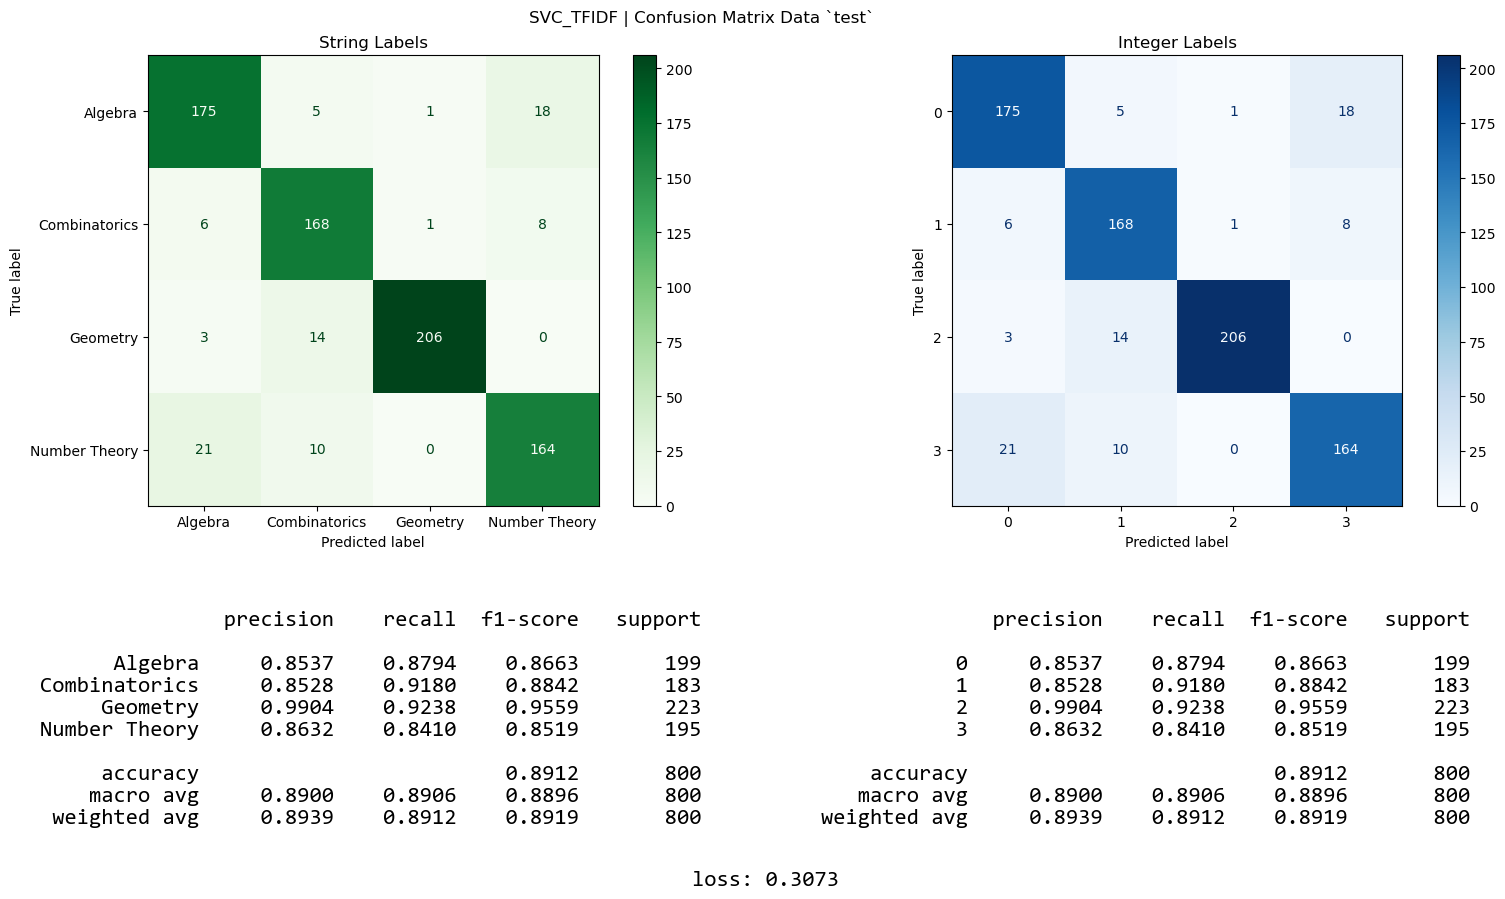

,index,text,actual,predicted,actual_int,predicted_int
63,190,Find all functions f: mathbb{R} rightarrow mat...,Algebra,Algebra,0,0
66,193,"Found all functions f: mathbb{R} to mathbb{R},...",Algebra,Algebra,0,0
346,277,A 9 times 12 rectangle is partitioned into uni...,Combinatorics,Combinatorics,1,1
533,392,A circle is called a separator for a set of fi...,Geometry,Combinatorics,2,1
490,576,"Let O, I, and omega be the circumcenter, the i...",Geometry,Geometry,2,2
456,600,Let P be a convex polygon. Prove that there ex...,Geometry,Geometry,2,2
696,771,"Find all pairs of positive integers (s, t), so...",Number Theory,Number Theory,3,3
667,792,Let left { {{a}_{n}} right }_{n geq 1} and lef...,Number Theory,Number Theory,3,3
621,745,Find all prime numbers p such that (x + y)^{19...,Number Theory,Number Theory,3,3
760,687,"Let (x_n), n=1,2, ldots be a sequence defined ...",Number Theory,Algebra,3,0


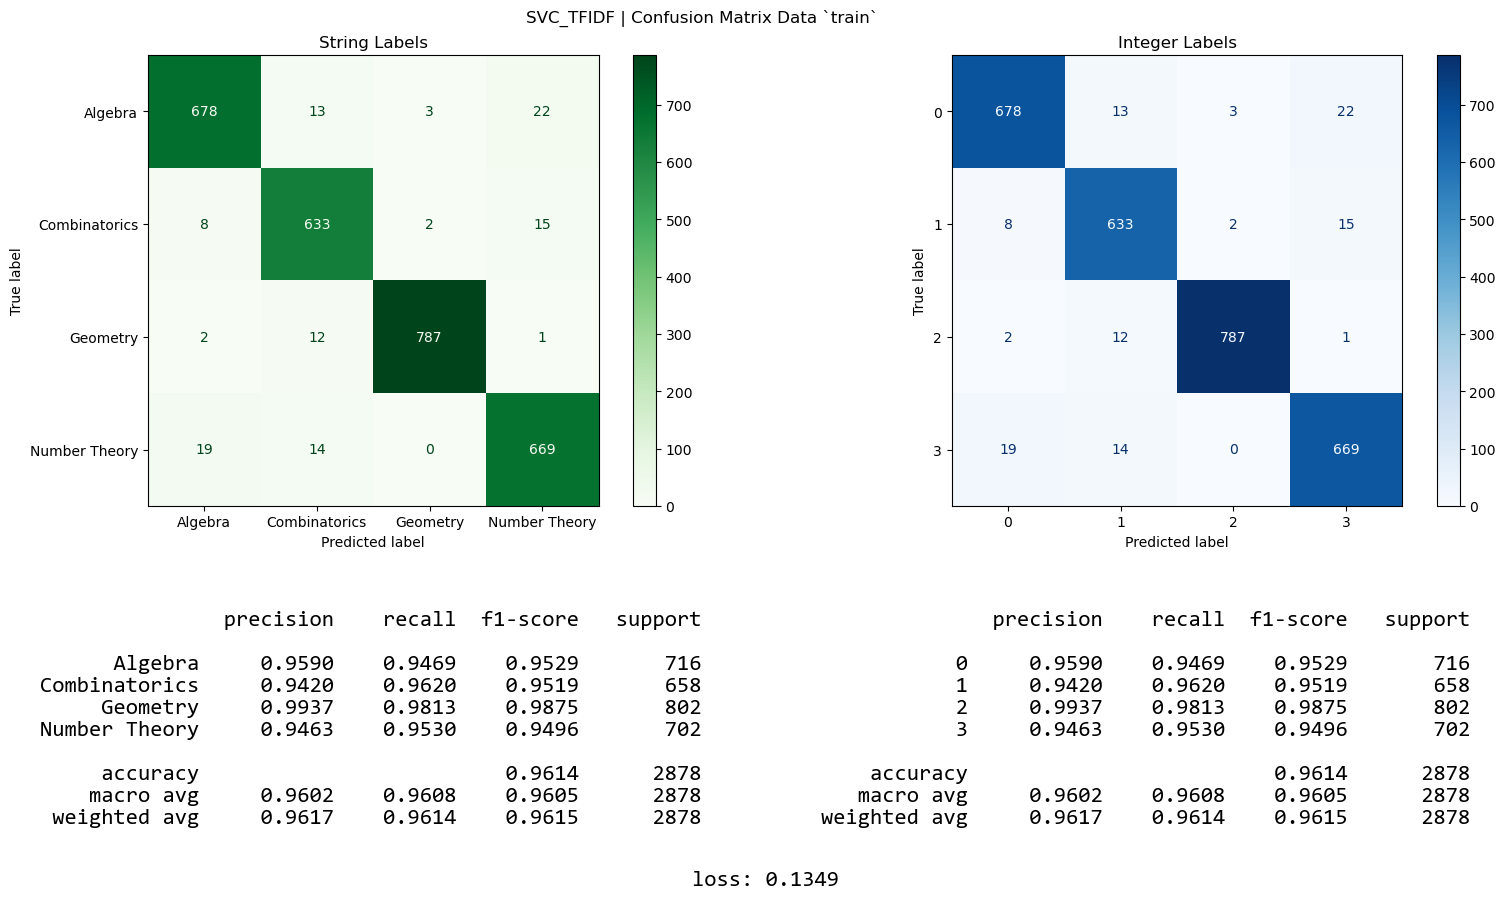

,index,text,actual,predicted,actual_int,predicted_int
471,20,"Prove that for all positive real numbers a,b,c...",Algebra,Algebra,0,0
1094,867,"Let E = {1, 2, dots , 16 } and let M be the co...",Combinatorics,Combinatorics,1,1
1255,1029,Two squares on an 8 times 8 chessboard are cal...,Combinatorics,Combinatorics,1,1
1128,795,"Let n geq 2, n in mathbb{N} and A_0 = (a_{01},...",Combinatorics,Algebra,1,0
945,1339,"On the board are written 2 , 3 , 5 ,... , 2003...",Combinatorics,Combinatorics,1,1
1453,1932,In a right-angled triangle ABC ( angle A = 90^...,Geometry,Geometry,2,2
1601,2080,Let ABCD be a rectangle of sides AB = 4 and BC...,Geometry,Geometry,2,2
1800,1499,Let ABC be an arbitrary triangle and M a point...,Geometry,Geometry,2,2
2376,2794,Find all functions g: mathbb{N} rightarrow mat...,Number Theory,Number Theory,3,3
2251,2671,"Let nu be an irrational positive number, and l...",Number Theory,Number Theory,3,3


Already exist --> 'saved_models/classification/SVC_TFIDF' NOT CREATED
Saved: "saved_models/classification/SVC_TFIDF/model.pkl"
Saved: "saved_models/classification/SVC_TFIDF/vectorizer.pkl"


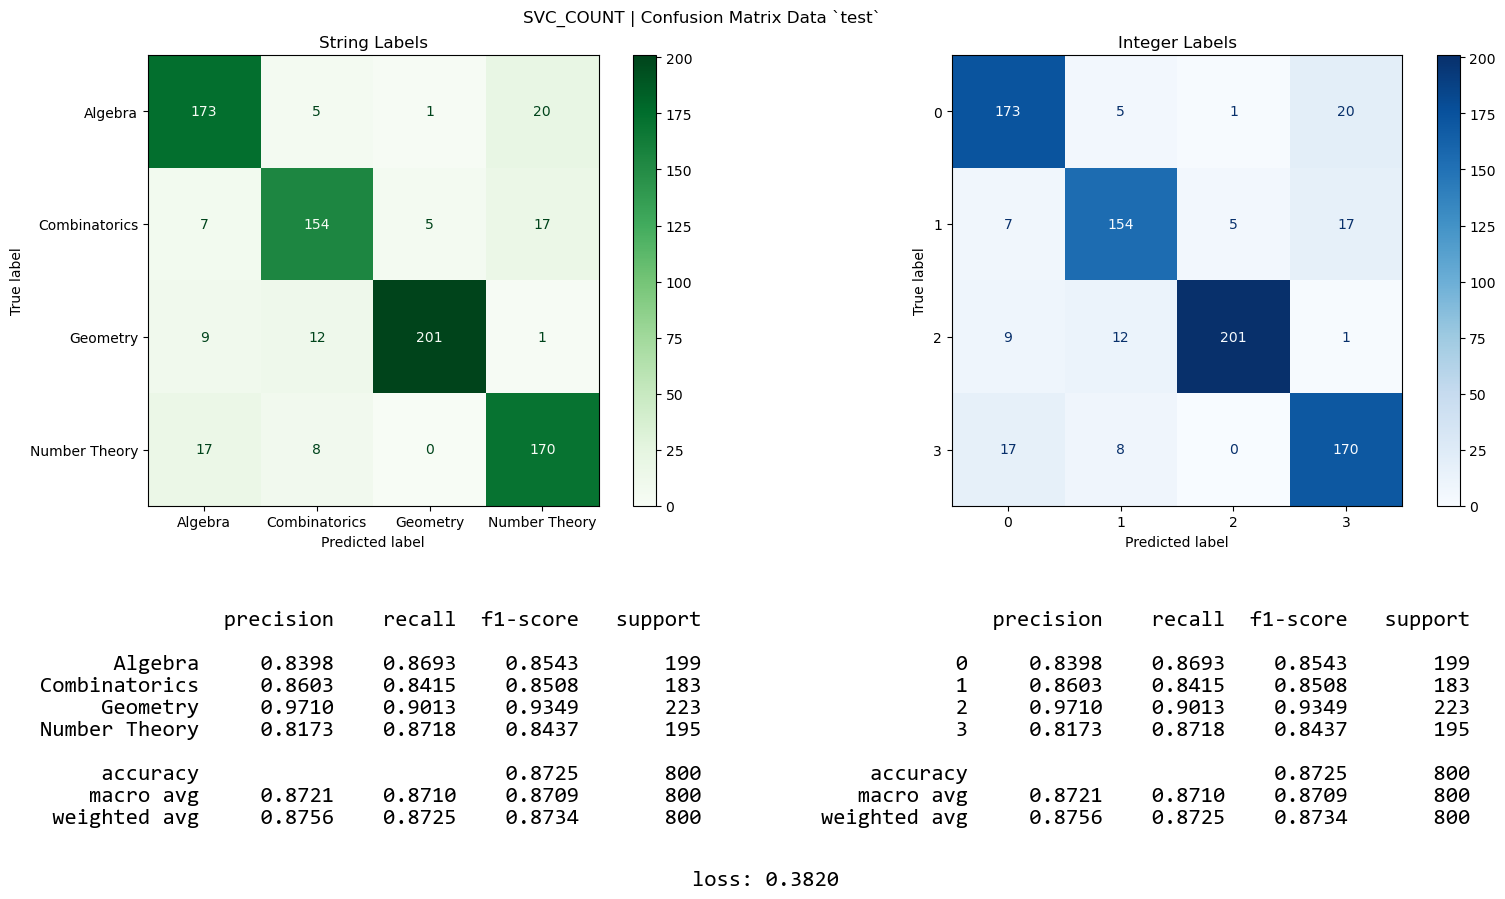

,index,text,actual,predicted,actual_int,predicted_int
63,190,Find all functions f: mathbb{R} rightarrow mat...,Algebra,Algebra,0,0
66,193,"Found all functions f: mathbb{R} to mathbb{R},...",Algebra,Algebra,0,0
346,277,A 9 times 12 rectangle is partitioned into uni...,Combinatorics,Combinatorics,1,1
533,392,A circle is called a separator for a set of fi...,Geometry,Combinatorics,2,1
490,576,"Let O, I, and omega be the circumcenter, the i...",Geometry,Geometry,2,2
456,600,Let P be a convex polygon. Prove that there ex...,Geometry,Geometry,2,2
696,771,"Find all pairs of positive integers (s, t), so...",Number Theory,Number Theory,3,3
667,792,Let left { {{a}_{n}} right }_{n geq 1} and lef...,Number Theory,Number Theory,3,3
621,745,Find all prime numbers p such that (x + y)^{19...,Number Theory,Number Theory,3,3
760,687,"Let (x_n), n=1,2, ldots be a sequence defined ...",Number Theory,Number Theory,3,3


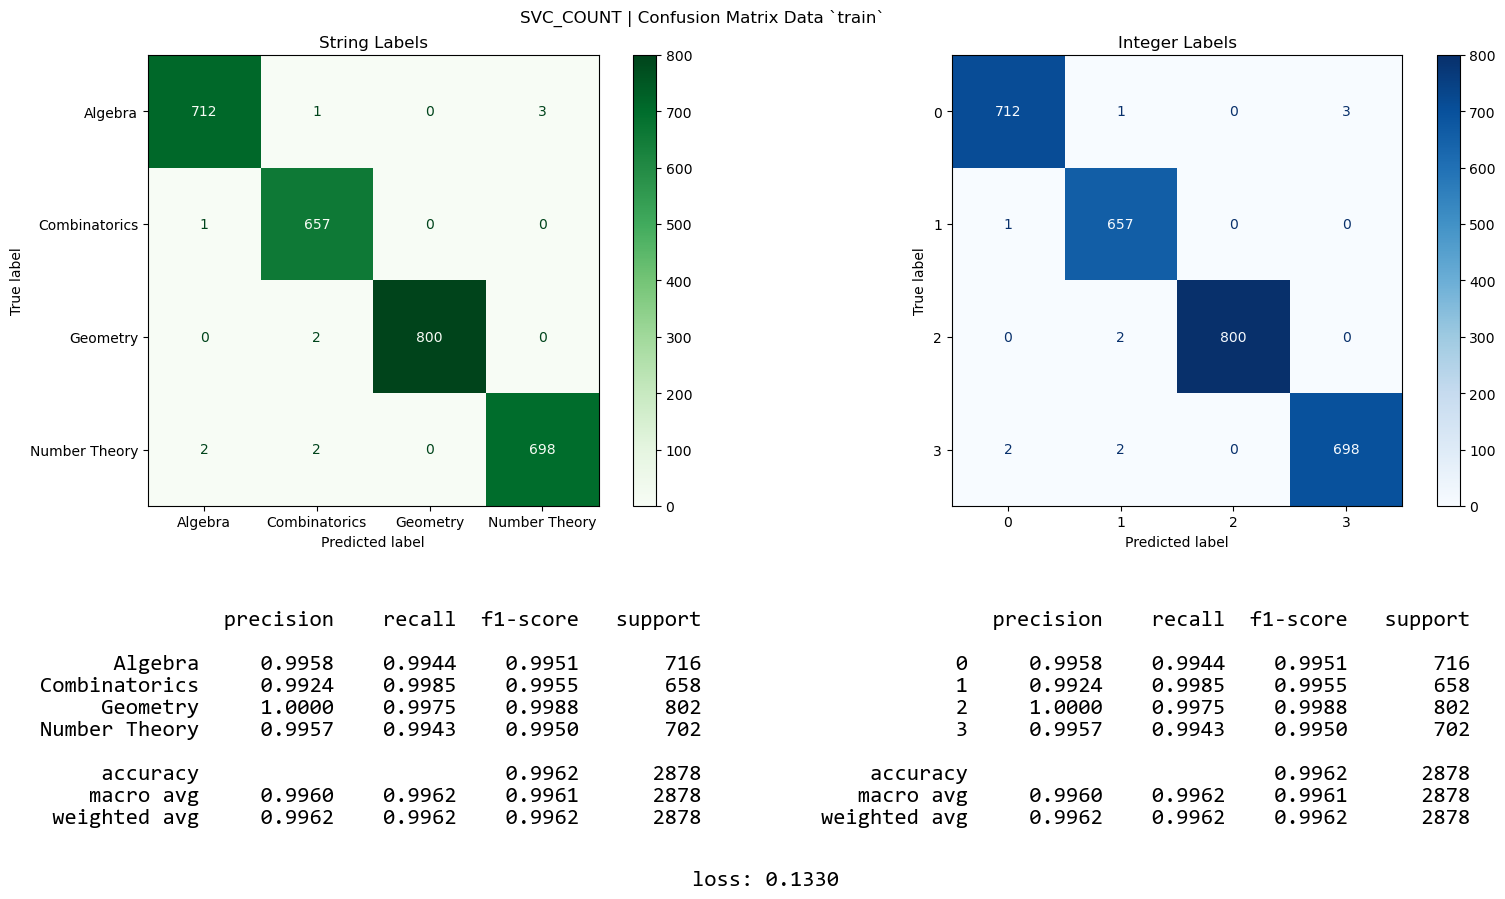

,index,text,actual,predicted,actual_int,predicted_int
471,20,"Prove that for all positive real numbers a,b,c...",Algebra,Algebra,0,0
1094,867,"Let E = {1, 2, dots , 16 } and let M be the co...",Combinatorics,Combinatorics,1,1
1255,1029,Two squares on an 8 times 8 chessboard are cal...,Combinatorics,Combinatorics,1,1
1128,795,"Let n geq 2, n in mathbb{N} and A_0 = (a_{01},...",Combinatorics,Combinatorics,1,1
945,1339,"On the board are written 2 , 3 , 5 ,... , 2003...",Combinatorics,Combinatorics,1,1
1453,1932,In a right-angled triangle ABC ( angle A = 90^...,Geometry,Geometry,2,2
1601,2080,Let ABCD be a rectangle of sides AB = 4 and BC...,Geometry,Geometry,2,2
1800,1499,Let ABC be an arbitrary triangle and M a point...,Geometry,Geometry,2,2
2376,2794,Find all functions g: mathbb{N} rightarrow mat...,Number Theory,Number Theory,3,3
2251,2671,"Let nu be an irrational positive number, and l...",Number Theory,Number Theory,3,3


Already exist --> 'saved_models/classification/SVC_COUNT' NOT CREATED
Saved: "saved_models/classification/SVC_COUNT/model.pkl"
Saved: "saved_models/classification/SVC_COUNT/vectorizer.pkl"


In [4]:
model = SVC()
md_name = "SVC"

# TFIDF
id_note = "11"
model, tfidf_test_result, _ = super_complete_compile_sklearn_model(id_note, model, TFIDF_vectorizer, train_texts, train_str_labels, train_int_labels, test_texts, test_str_labels, test_int_labels)
temp = f"{id_note},classification,{md_name},TfidfVectorizer,-,-,-,-,-,{tfidf_test_result['training_time']:.2f},"
temp+= f"{tfidf_test_result['loss']:.7f},{tfidf_test_result['accuracy']:.7f},{tfidf_test_result['macro avg']['precision']:.7f},"
temp+= f"{tfidf_test_result['macro avg']['recall']:.7f},{tfidf_test_result['macro avg']['f1-score']:.7f}"
append_training_result("Hasil training - Classification.csv", temp)

# Save model
directory = f"saved_models/classification/{md_name}_TFIDF"
create_folder(directory)
save_pkl(model, f"{directory}/model.pkl")
save_pkl(TFIDF_vectorizer, f"{directory}/vectorizer.pkl")


# COUNTVECTORIZER
id_note = "12"
model, count_test_result, _ = super_complete_compile_sklearn_model(id_note, model, COUNT_vectorizer, train_texts, train_str_labels, train_int_labels, test_texts, test_str_labels, test_int_labels)
temp = f"{id_note},classification,{md_name},CountVectorizer,-,-,-,-,-,{count_test_result['training_time']:.2f},"
temp+= f"{count_test_result['loss']:.7f},{count_test_result['accuracy']:.7f},{count_test_result['macro avg']['precision']:.7f},"
temp+= f"{count_test_result['macro avg']['recall']:.7f},{count_test_result['macro avg']['f1-score']:.7f}"
append_training_result("Hasil training - Classification.csv", temp)

# Save model
directory = f"saved_models/classification/{md_name}_COUNT"
create_folder(directory)
save_pkl(model, f"{directory}/model.pkl")
save_pkl(COUNT_vectorizer, f"{directory}/vectorizer.pkl")


### RandomForestClassifier

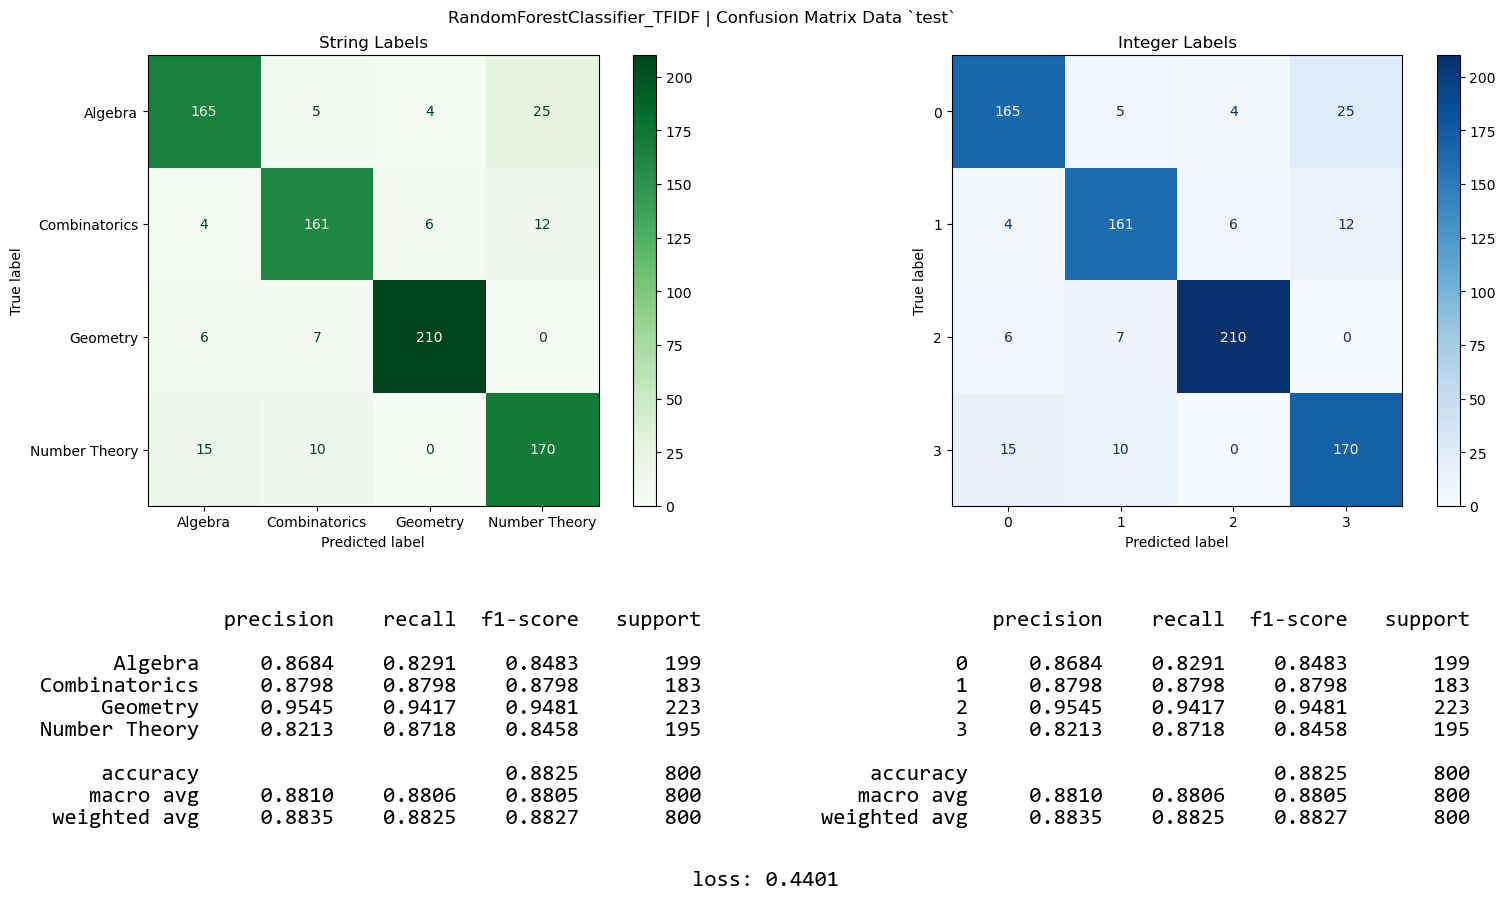

,index,text,actual,predicted,actual_int,predicted_int
63,190,Find all functions f: mathbb{R} rightarrow mat...,Algebra,Algebra,0,0
66,193,"Found all functions f: mathbb{R} to mathbb{R},...",Algebra,Algebra,0,0
346,277,A 9 times 12 rectangle is partitioned into uni...,Combinatorics,Combinatorics,1,1
533,392,A circle is called a separator for a set of fi...,Geometry,Geometry,2,2
490,576,"Let O, I, and omega be the circumcenter, the i...",Geometry,Geometry,2,2
456,600,Let P be a convex polygon. Prove that there ex...,Geometry,Geometry,2,2
696,771,"Find all pairs of positive integers (s, t), so...",Number Theory,Number Theory,3,3
667,792,Let left { {{a}_{n}} right }_{n geq 1} and lef...,Number Theory,Combinatorics,3,1
621,745,Find all prime numbers p such that (x + y)^{19...,Number Theory,Number Theory,3,3
760,687,"Let (x_n), n=1,2, ldots be a sequence defined ...",Number Theory,Algebra,3,0


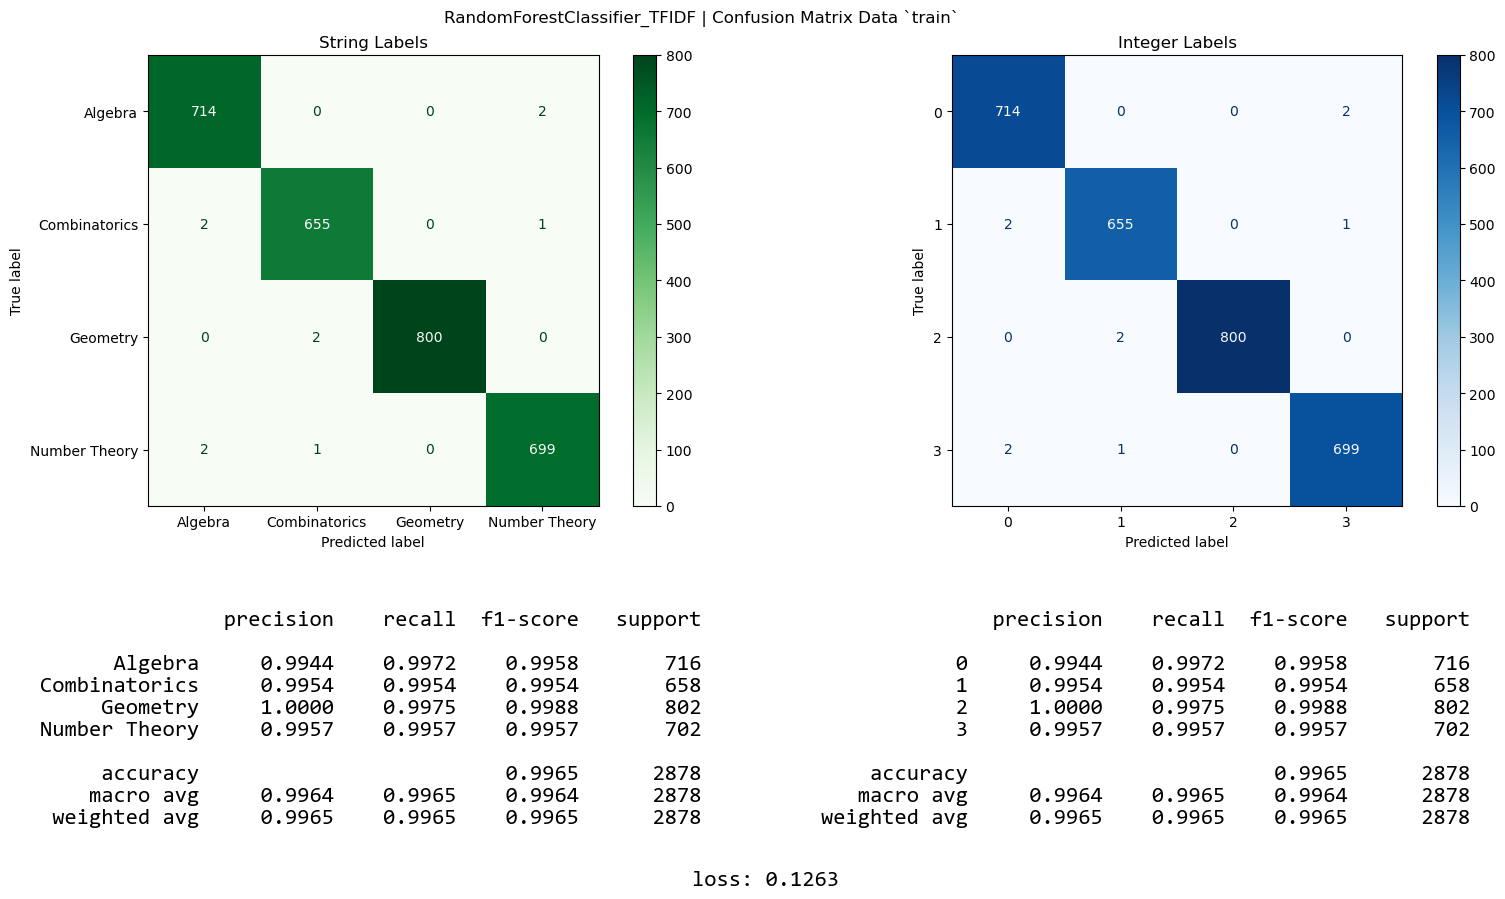

,index,text,actual,predicted,actual_int,predicted_int
471,20,"Prove that for all positive real numbers a,b,c...",Algebra,Algebra,0,0
1094,867,"Let E = {1, 2, dots , 16 } and let M be the co...",Combinatorics,Combinatorics,1,1
1255,1029,Two squares on an 8 times 8 chessboard are cal...,Combinatorics,Combinatorics,1,1
1128,795,"Let n geq 2, n in mathbb{N} and A_0 = (a_{01},...",Combinatorics,Combinatorics,1,1
945,1339,"On the board are written 2 , 3 , 5 ,... , 2003...",Combinatorics,Combinatorics,1,1
1453,1932,In a right-angled triangle ABC ( angle A = 90^...,Geometry,Geometry,2,2
1601,2080,Let ABCD be a rectangle of sides AB = 4 and BC...,Geometry,Geometry,2,2
1800,1499,Let ABC be an arbitrary triangle and M a point...,Geometry,Geometry,2,2
2376,2794,Find all functions g: mathbb{N} rightarrow mat...,Number Theory,Number Theory,3,3
2251,2671,"Let nu be an irrational positive number, and l...",Number Theory,Number Theory,3,3


Already exist --> 'saved_models/classification/RandomForestClassifier_TFIDF' NOT CREATED
Saved: "saved_models/classification/RandomForestClassifier_TFIDF/model.pkl"
Saved: "saved_models/classification/RandomForestClassifier_TFIDF/vectorizer.pkl"


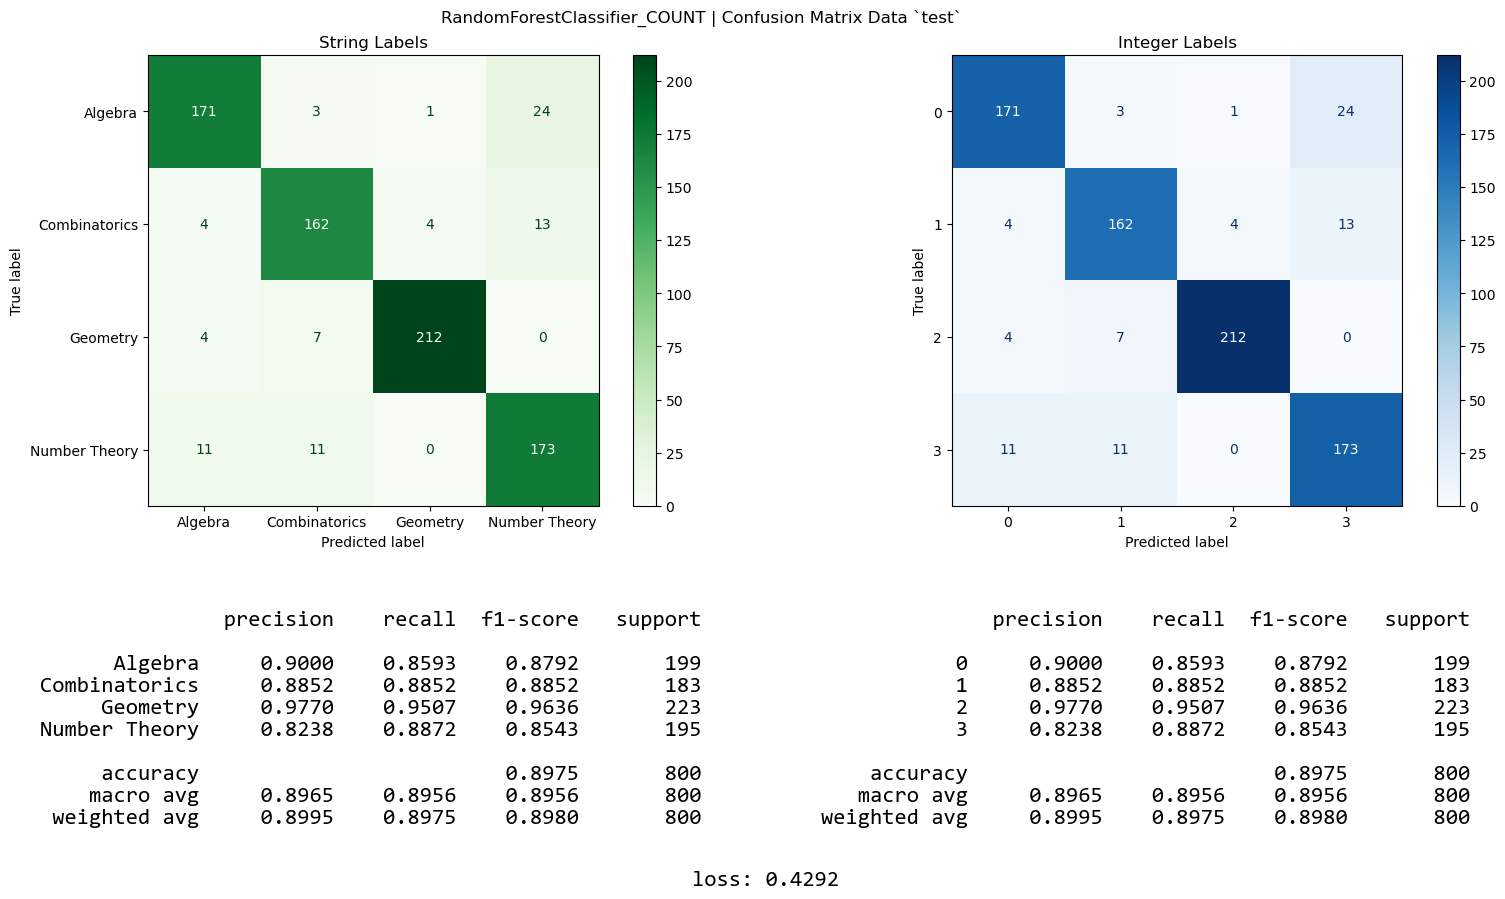

,index,text,actual,predicted,actual_int,predicted_int
63,190,Find all functions f: mathbb{R} rightarrow mat...,Algebra,Algebra,0,0
66,193,"Found all functions f: mathbb{R} to mathbb{R},...",Algebra,Algebra,0,0
346,277,A 9 times 12 rectangle is partitioned into uni...,Combinatorics,Combinatorics,1,1
533,392,A circle is called a separator for a set of fi...,Geometry,Combinatorics,2,1
490,576,"Let O, I, and omega be the circumcenter, the i...",Geometry,Geometry,2,2
456,600,Let P be a convex polygon. Prove that there ex...,Geometry,Geometry,2,2
696,771,"Find all pairs of positive integers (s, t), so...",Number Theory,Number Theory,3,3
667,792,Let left { {{a}_{n}} right }_{n geq 1} and lef...,Number Theory,Combinatorics,3,1
621,745,Find all prime numbers p such that (x + y)^{19...,Number Theory,Number Theory,3,3
760,687,"Let (x_n), n=1,2, ldots be a sequence defined ...",Number Theory,Algebra,3,0


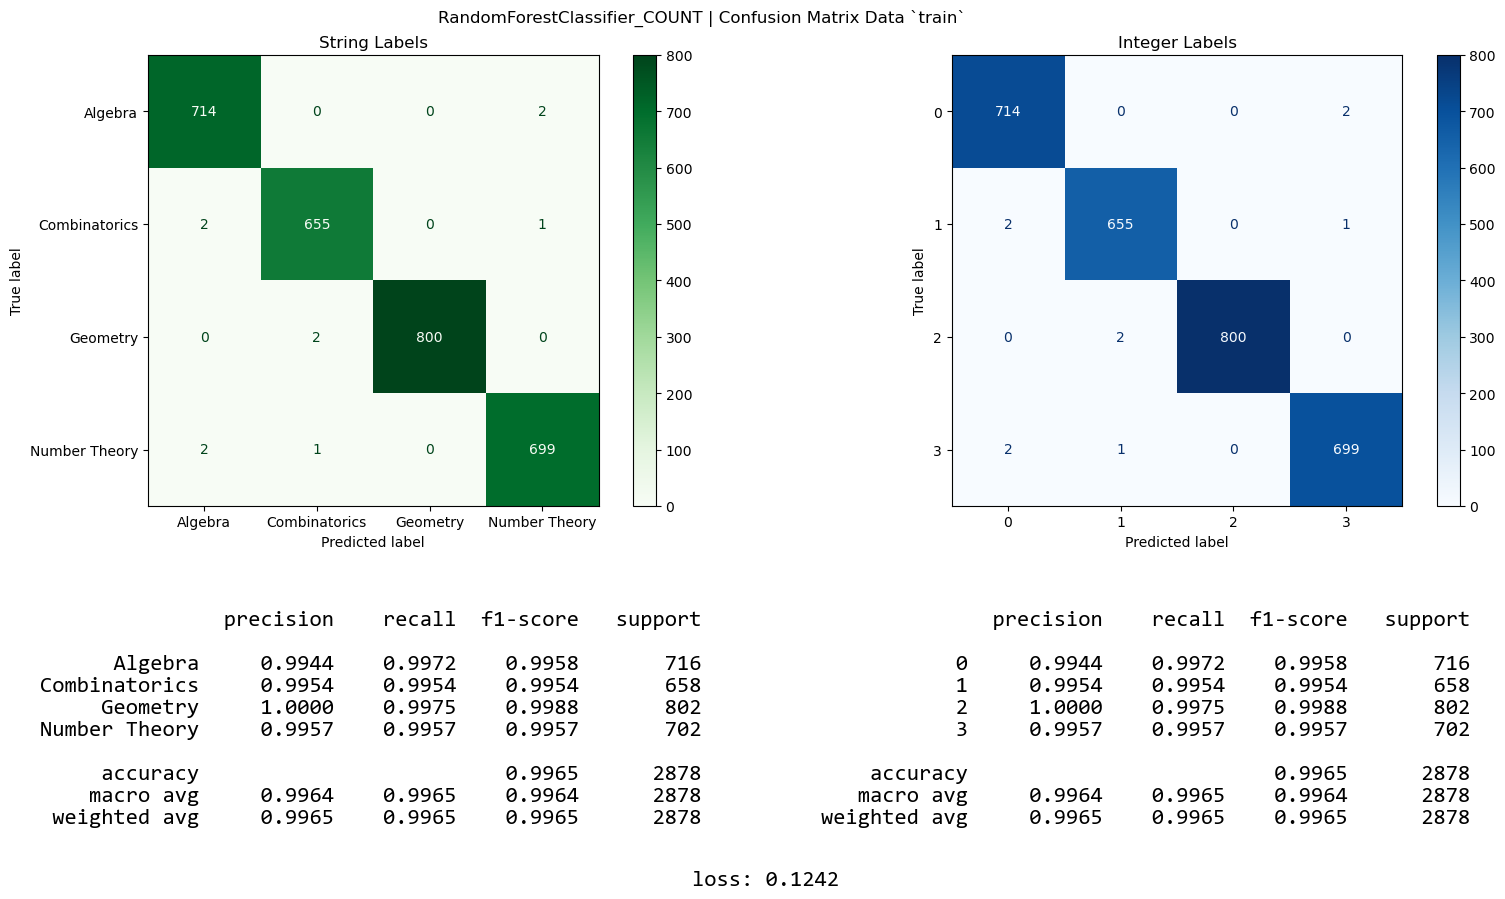

,index,text,actual,predicted,actual_int,predicted_int
471,20,"Prove that for all positive real numbers a,b,c...",Algebra,Algebra,0,0
1094,867,"Let E = {1, 2, dots , 16 } and let M be the co...",Combinatorics,Combinatorics,1,1
1255,1029,Two squares on an 8 times 8 chessboard are cal...,Combinatorics,Combinatorics,1,1
1128,795,"Let n geq 2, n in mathbb{N} and A_0 = (a_{01},...",Combinatorics,Combinatorics,1,1
945,1339,"On the board are written 2 , 3 , 5 ,... , 2003...",Combinatorics,Combinatorics,1,1
1453,1932,In a right-angled triangle ABC ( angle A = 90^...,Geometry,Geometry,2,2
1601,2080,Let ABCD be a rectangle of sides AB = 4 and BC...,Geometry,Geometry,2,2
1800,1499,Let ABC be an arbitrary triangle and M a point...,Geometry,Geometry,2,2
2376,2794,Find all functions g: mathbb{N} rightarrow mat...,Number Theory,Number Theory,3,3
2251,2671,"Let nu be an irrational positive number, and l...",Number Theory,Number Theory,3,3


Already exist --> 'saved_models/classification/RandomForestClassifier_COUNT' NOT CREATED
Saved: "saved_models/classification/RandomForestClassifier_COUNT/model.pkl"
Saved: "saved_models/classification/RandomForestClassifier_COUNT/vectorizer.pkl"


In [5]:
model = RandomForestClassifier()
md_name = "RandomForestClassifier"

# TFIDF
id_note = "13"
model, tfidf_test_result, _ = super_complete_compile_sklearn_model(id_note, model, TFIDF_vectorizer, train_texts, train_str_labels, train_int_labels, test_texts, test_str_labels, test_int_labels)
temp = f"{id_note},classification,{md_name},TfidfVectorizer,-,-,-,-,-,{tfidf_test_result['training_time']:.2f},"
temp+= f"{tfidf_test_result['loss']:.7f},{tfidf_test_result['accuracy']:.7f},{tfidf_test_result['macro avg']['precision']:.7f},"
temp+= f"{tfidf_test_result['macro avg']['recall']:.7f},{tfidf_test_result['macro avg']['f1-score']:.7f}"
append_training_result("Hasil training - Classification.csv", temp)

# Save model
directory = f"saved_models/classification/{md_name}_TFIDF"
create_folder(directory)
save_pkl(model, f"{directory}/model.pkl")
save_pkl(TFIDF_vectorizer, f"{directory}/vectorizer.pkl")


# COUNTVECTORIZER
id_note = "14"
model, count_test_result, _ = super_complete_compile_sklearn_model(id_note, model, COUNT_vectorizer, train_texts, train_str_labels, train_int_labels, test_texts, test_str_labels, test_int_labels)
temp = f"{id_note},classification,{md_name},CountVectorizer,-,-,-,-,-,{count_test_result['training_time']:.2f},"
temp+= f"{count_test_result['loss']:.7f},{count_test_result['accuracy']:.7f},{count_test_result['macro avg']['precision']:.7f},"
temp+= f"{count_test_result['macro avg']['recall']:.7f},{count_test_result['macro avg']['f1-score']:.7f}"
append_training_result("Hasil training - Classification.csv", temp)

# Save model
directory = f"saved_models/classification/{md_name}_COUNT"
create_folder(directory)
save_pkl(model, f"{directory}/model.pkl")
save_pkl(COUNT_vectorizer, f"{directory}/vectorizer.pkl")


### KNeighborsClassifier

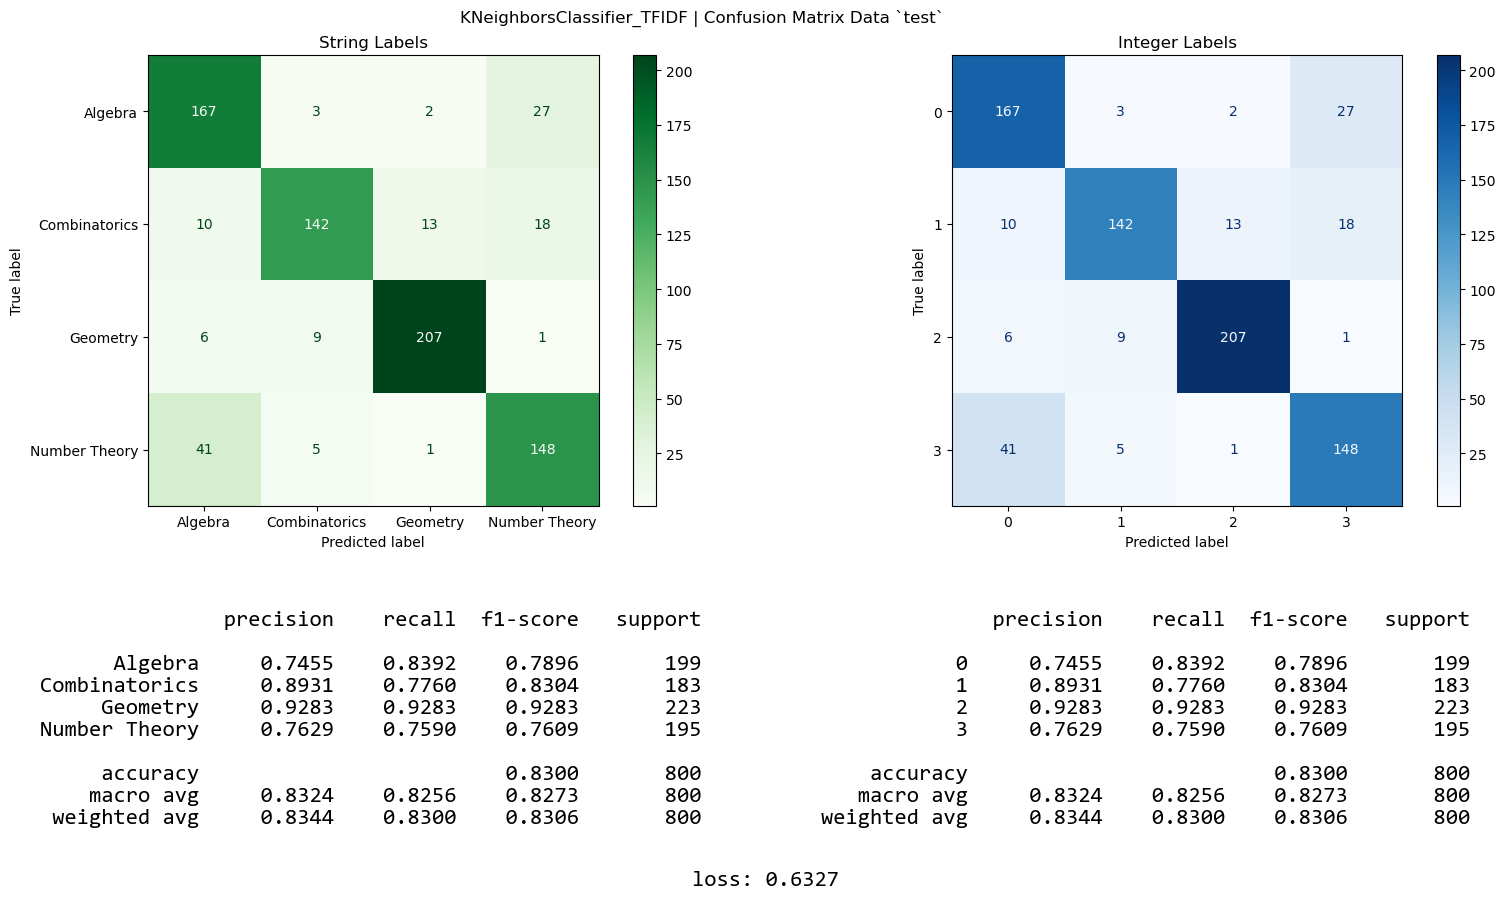

,index,text,actual,predicted,actual_int,predicted_int
63,190,Find all functions f: mathbb{R} rightarrow mat...,Algebra,Algebra,0,0
66,193,"Found all functions f: mathbb{R} to mathbb{R},...",Algebra,Algebra,0,0
346,277,A 9 times 12 rectangle is partitioned into uni...,Combinatorics,Combinatorics,1,1
533,392,A circle is called a separator for a set of fi...,Geometry,Combinatorics,2,1
490,576,"Let O, I, and omega be the circumcenter, the i...",Geometry,Geometry,2,2
456,600,Let P be a convex polygon. Prove that there ex...,Geometry,Geometry,2,2
696,771,"Find all pairs of positive integers (s, t), so...",Number Theory,Number Theory,3,3
667,792,Let left { {{a}_{n}} right }_{n geq 1} and lef...,Number Theory,Algebra,3,0
621,745,Find all prime numbers p such that (x + y)^{19...,Number Theory,Number Theory,3,3
760,687,"Let (x_n), n=1,2, ldots be a sequence defined ...",Number Theory,Algebra,3,0


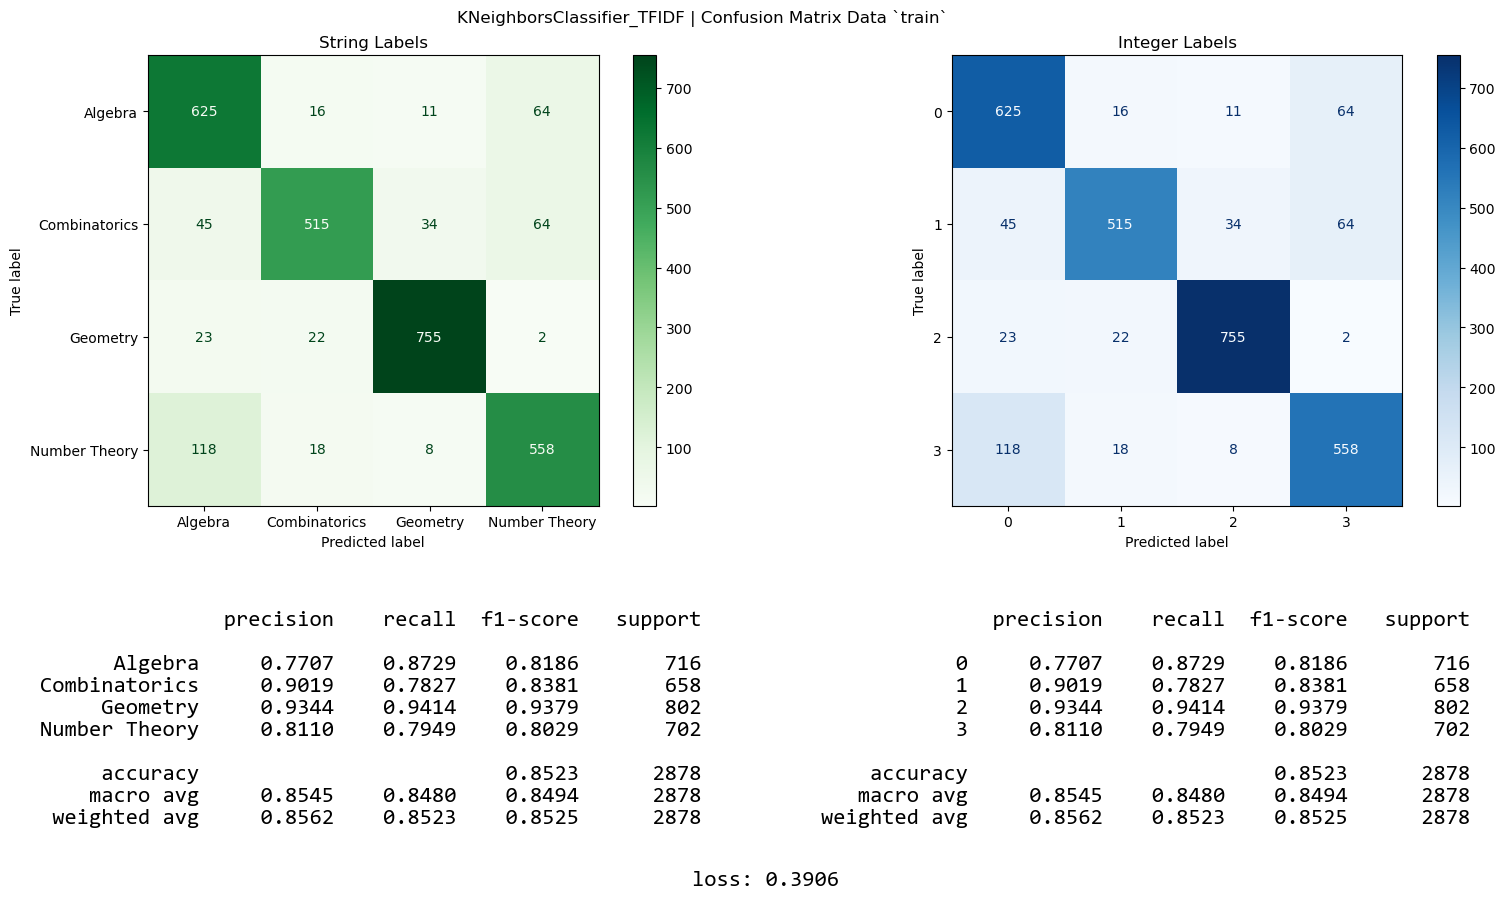

,index,text,actual,predicted,actual_int,predicted_int
471,20,"Prove that for all positive real numbers a,b,c...",Algebra,Algebra,0,0
1094,867,"Let E = {1, 2, dots , 16 } and let M be the co...",Combinatorics,Combinatorics,1,1
1255,1029,Two squares on an 8 times 8 chessboard are cal...,Combinatorics,Combinatorics,1,1
1128,795,"Let n geq 2, n in mathbb{N} and A_0 = (a_{01},...",Combinatorics,Algebra,1,0
945,1339,"On the board are written 2 , 3 , 5 ,... , 2003...",Combinatorics,Number Theory,1,3
1453,1932,In a right-angled triangle ABC ( angle A = 90^...,Geometry,Geometry,2,2
1601,2080,Let ABCD be a rectangle of sides AB = 4 and BC...,Geometry,Geometry,2,2
1800,1499,Let ABC be an arbitrary triangle and M a point...,Geometry,Geometry,2,2
2376,2794,Find all functions g: mathbb{N} rightarrow mat...,Number Theory,Algebra,3,0
2251,2671,"Let nu be an irrational positive number, and l...",Number Theory,Number Theory,3,3


Already exist --> 'saved_models/classification/KNeighborsClassifier_TFIDF' NOT CREATED
Saved: "saved_models/classification/KNeighborsClassifier_TFIDF/model.pkl"
Saved: "saved_models/classification/KNeighborsClassifier_TFIDF/vectorizer.pkl"


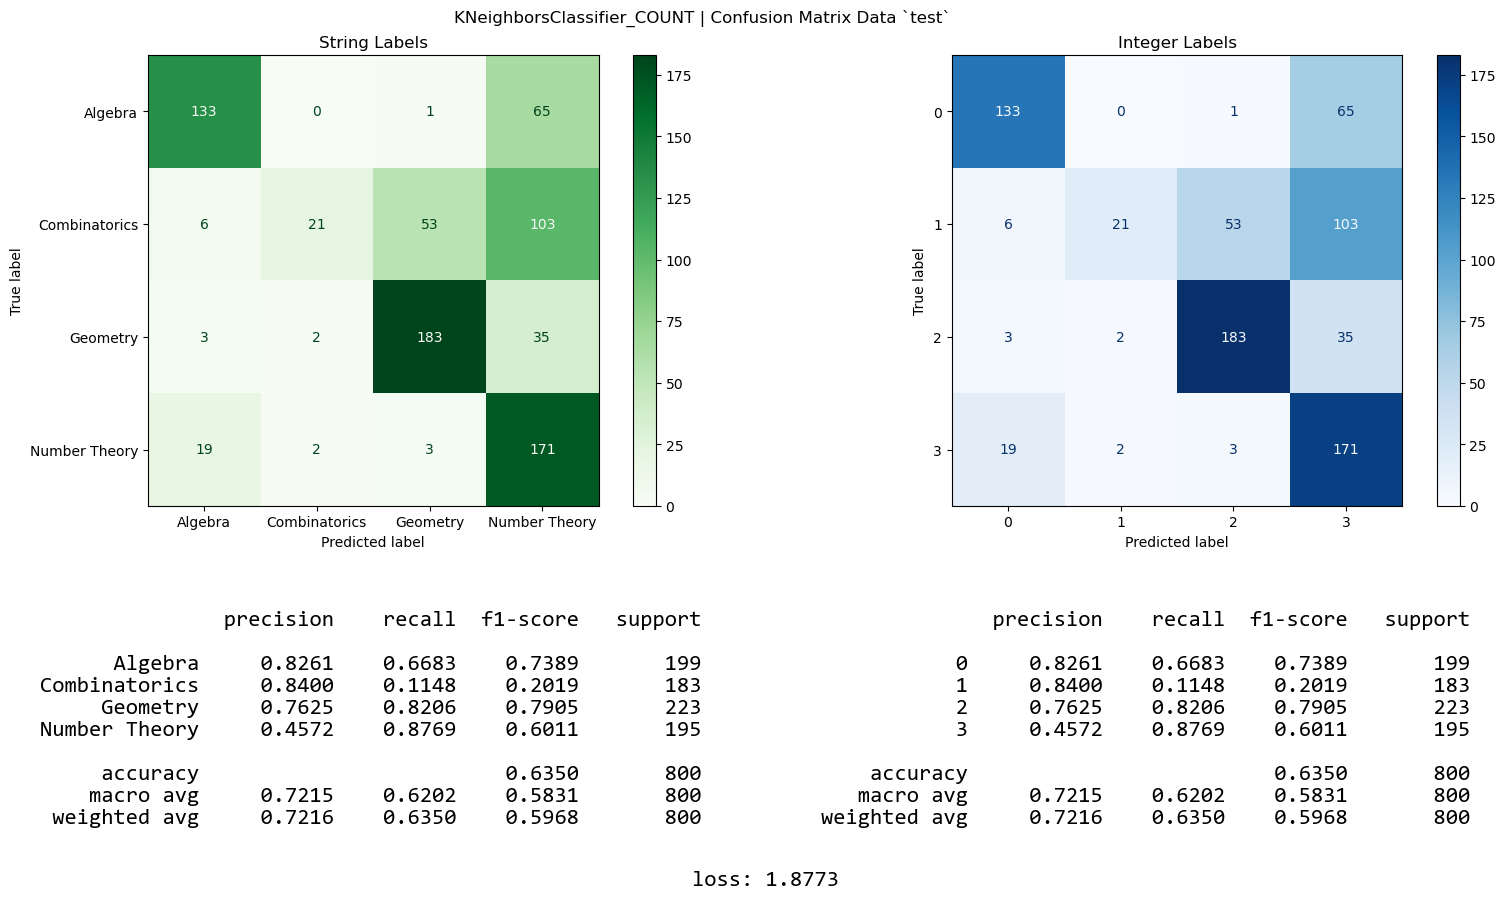

,index,text,actual,predicted,actual_int,predicted_int
63,190,Find all functions f: mathbb{R} rightarrow mat...,Algebra,Algebra,0,0
66,193,"Found all functions f: mathbb{R} to mathbb{R},...",Algebra,Algebra,0,0
346,277,A 9 times 12 rectangle is partitioned into uni...,Combinatorics,Number Theory,1,3
533,392,A circle is called a separator for a set of fi...,Geometry,Combinatorics,2,1
490,576,"Let O, I, and omega be the circumcenter, the i...",Geometry,Geometry,2,2
456,600,Let P be a convex polygon. Prove that there ex...,Geometry,Geometry,2,2
696,771,"Find all pairs of positive integers (s, t), so...",Number Theory,Number Theory,3,3
667,792,Let left { {{a}_{n}} right }_{n geq 1} and lef...,Number Theory,Algebra,3,0
621,745,Find all prime numbers p such that (x + y)^{19...,Number Theory,Number Theory,3,3
760,687,"Let (x_n), n=1,2, ldots be a sequence defined ...",Number Theory,Algebra,3,0


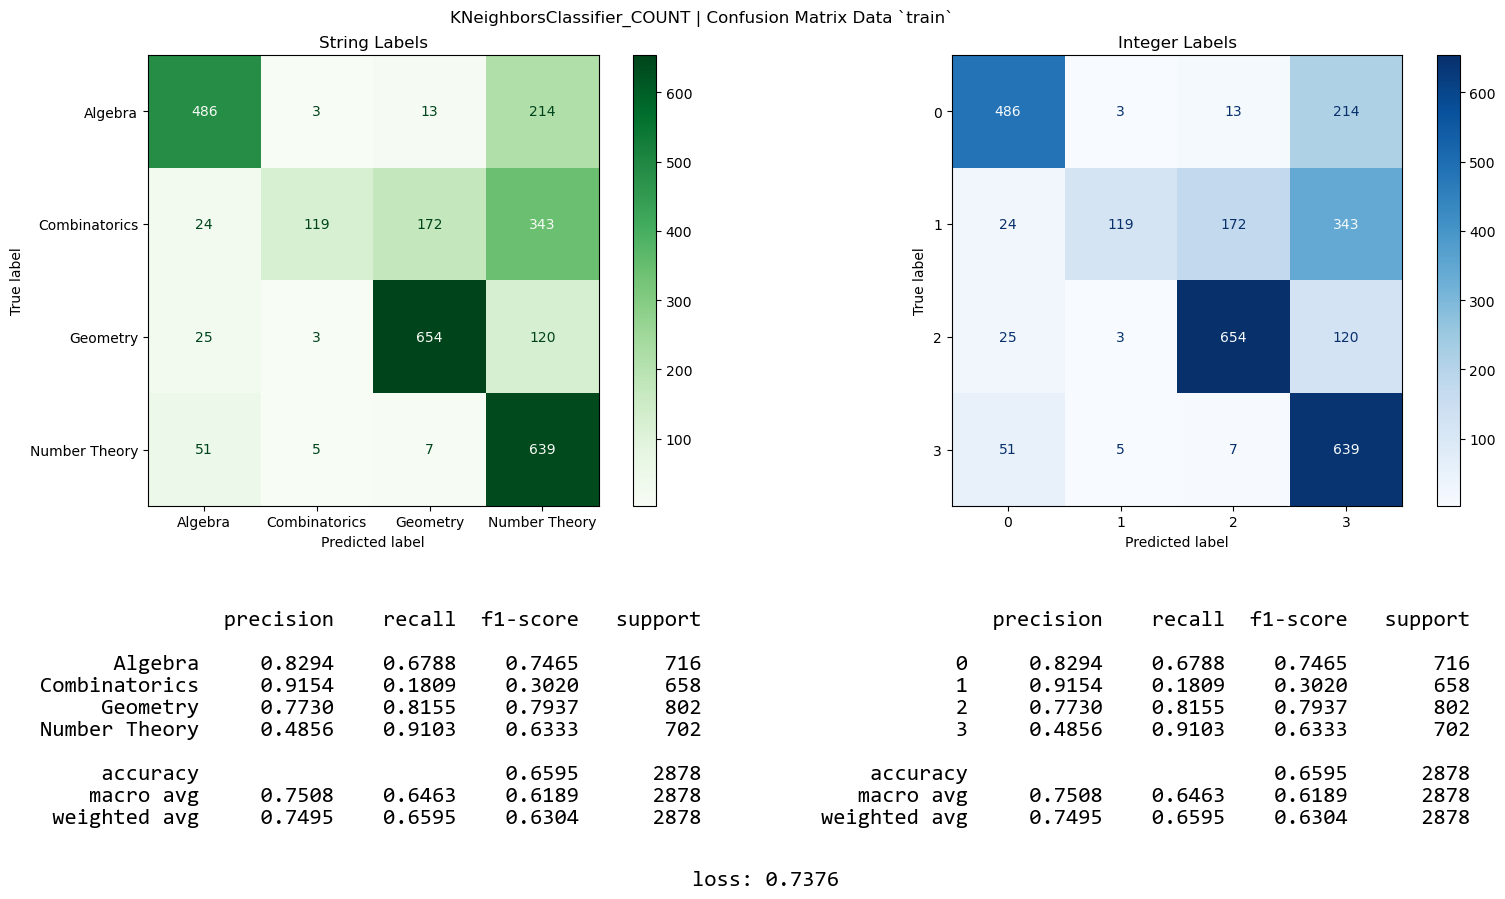

,index,text,actual,predicted,actual_int,predicted_int
471,20,"Prove that for all positive real numbers a,b,c...",Algebra,Algebra,0,0
1094,867,"Let E = {1, 2, dots , 16 } and let M be the co...",Combinatorics,Number Theory,1,3
1255,1029,Two squares on an 8 times 8 chessboard are cal...,Combinatorics,Number Theory,1,3
1128,795,"Let n geq 2, n in mathbb{N} and A_0 = (a_{01},...",Combinatorics,Algebra,1,0
945,1339,"On the board are written 2 , 3 , 5 ,... , 2003...",Combinatorics,Combinatorics,1,1
1453,1932,In a right-angled triangle ABC ( angle A = 90^...,Geometry,Geometry,2,2
1601,2080,Let ABCD be a rectangle of sides AB = 4 and BC...,Geometry,Geometry,2,2
1800,1499,Let ABC be an arbitrary triangle and M a point...,Geometry,Geometry,2,2
2376,2794,Find all functions g: mathbb{N} rightarrow mat...,Number Theory,Algebra,3,0
2251,2671,"Let nu be an irrational positive number, and l...",Number Theory,Number Theory,3,3


Already exist --> 'saved_models/classification/KNeighborsClassifier_COUNT' NOT CREATED
Saved: "saved_models/classification/KNeighborsClassifier_COUNT/model.pkl"
Saved: "saved_models/classification/KNeighborsClassifier_COUNT/vectorizer.pkl"


In [6]:
model = KNeighborsClassifier()
md_name = "KNeighborsClassifier"

# TFIDF
id_note = "15"
model, tfidf_test_result, _ = super_complete_compile_sklearn_model(id_note, model, TFIDF_vectorizer, train_texts, train_str_labels, train_int_labels, test_texts, test_str_labels, test_int_labels)
temp = f"{id_note},classification,{md_name},TfidfVectorizer,-,-,-,-,-,{tfidf_test_result['training_time']:.2f},"
temp+= f"{tfidf_test_result['loss']:.7f},{tfidf_test_result['accuracy']:.7f},{tfidf_test_result['macro avg']['precision']:.7f},"
temp+= f"{tfidf_test_result['macro avg']['recall']:.7f},{tfidf_test_result['macro avg']['f1-score']:.7f}"
append_training_result("Hasil training - Classification.csv", temp)

# Save model
directory = f"saved_models/classification/{md_name}_TFIDF"
create_folder(directory)
save_pkl(model, f"{directory}/model.pkl")
save_pkl(TFIDF_vectorizer, f"{directory}/vectorizer.pkl")


# COUNTVECTORIZER
id_note = "16"
model, count_test_result, _ = super_complete_compile_sklearn_model(id_note, model, COUNT_vectorizer, train_texts, train_str_labels, train_int_labels, test_texts, test_str_labels, test_int_labels)
temp = f"{id_note},classification,{md_name},CountVectorizer,-,-,-,-,-,{count_test_result['training_time']:.2f},"
temp+= f"{count_test_result['loss']:.7f},{count_test_result['accuracy']:.7f},{count_test_result['macro avg']['precision']:.7f},"
temp+= f"{count_test_result['macro avg']['recall']:.7f},{count_test_result['macro avg']['f1-score']:.7f}"
append_training_result("Hasil training - Classification.csv", temp)

# Save model
directory = f"saved_models/classification/{md_name}_COUNT"
create_folder(directory)
save_pkl(model, f"{directory}/model.pkl")
save_pkl(COUNT_vectorizer, f"{directory}/vectorizer.pkl")


### LogisticRegression

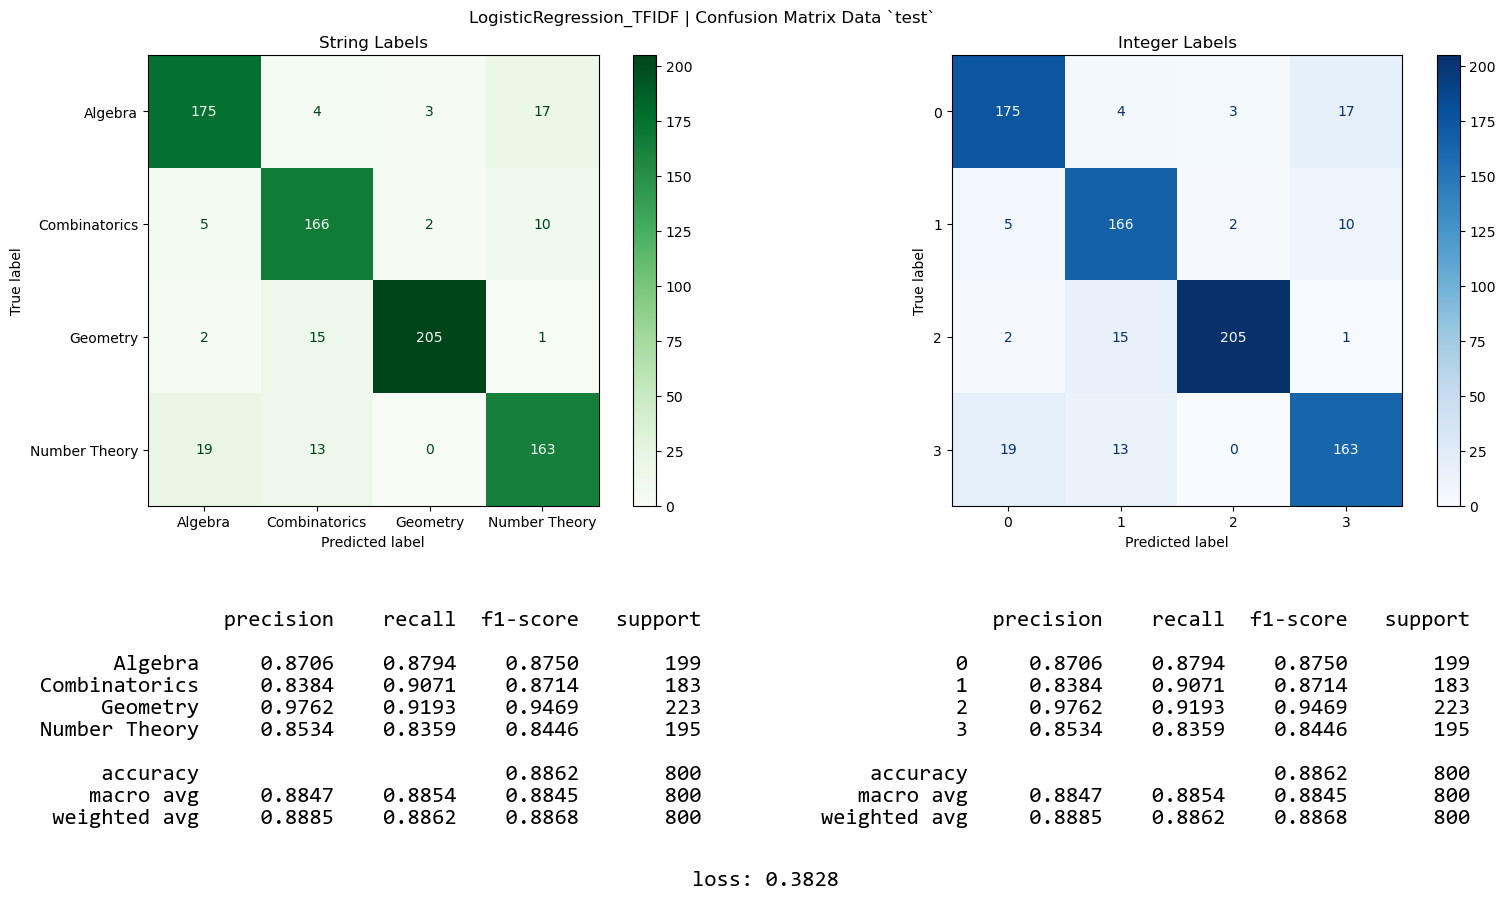

,index,text,actual,predicted,actual_int,predicted_int
63,190,Find all functions f: mathbb{R} rightarrow mat...,Algebra,Algebra,0,0
66,193,"Found all functions f: mathbb{R} to mathbb{R},...",Algebra,Algebra,0,0
346,277,A 9 times 12 rectangle is partitioned into uni...,Combinatorics,Combinatorics,1,1
533,392,A circle is called a separator for a set of fi...,Geometry,Combinatorics,2,1
490,576,"Let O, I, and omega be the circumcenter, the i...",Geometry,Geometry,2,2
456,600,Let P be a convex polygon. Prove that there ex...,Geometry,Geometry,2,2
696,771,"Find all pairs of positive integers (s, t), so...",Number Theory,Number Theory,3,3
667,792,Let left { {{a}_{n}} right }_{n geq 1} and lef...,Number Theory,Number Theory,3,3
621,745,Find all prime numbers p such that (x + y)^{19...,Number Theory,Number Theory,3,3
760,687,"Let (x_n), n=1,2, ldots be a sequence defined ...",Number Theory,Algebra,3,0


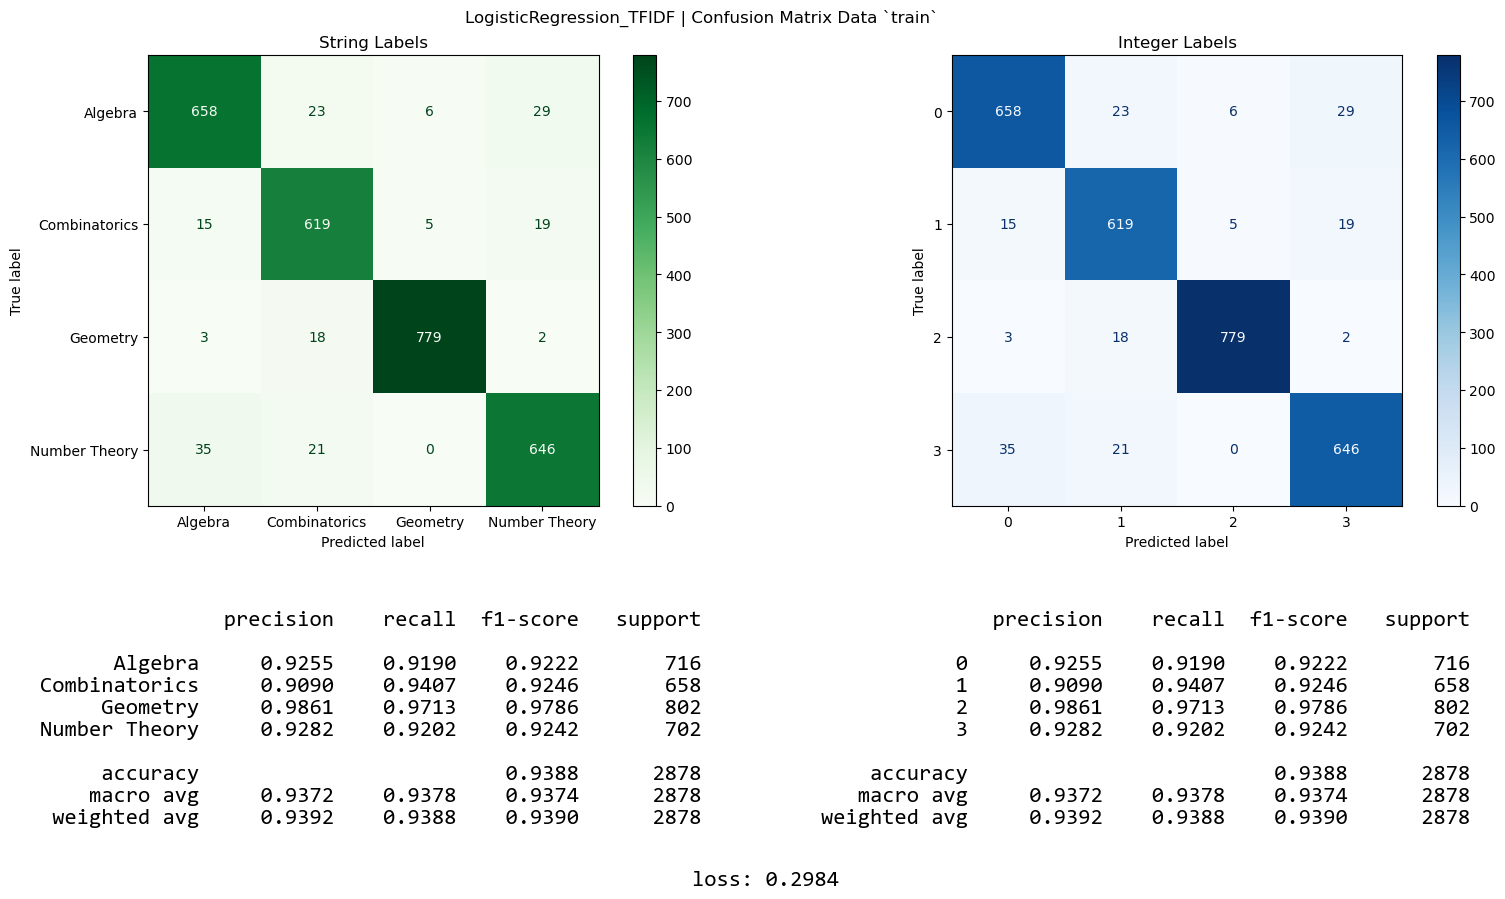

,index,text,actual,predicted,actual_int,predicted_int
471,20,"Prove that for all positive real numbers a,b,c...",Algebra,Algebra,0,0
1094,867,"Let E = {1, 2, dots , 16 } and let M be the co...",Combinatorics,Combinatorics,1,1
1255,1029,Two squares on an 8 times 8 chessboard are cal...,Combinatorics,Combinatorics,1,1
1128,795,"Let n geq 2, n in mathbb{N} and A_0 = (a_{01},...",Combinatorics,Algebra,1,0
945,1339,"On the board are written 2 , 3 , 5 ,... , 2003...",Combinatorics,Combinatorics,1,1
1453,1932,In a right-angled triangle ABC ( angle A = 90^...,Geometry,Geometry,2,2
1601,2080,Let ABCD be a rectangle of sides AB = 4 and BC...,Geometry,Geometry,2,2
1800,1499,Let ABC be an arbitrary triangle and M a point...,Geometry,Geometry,2,2
2376,2794,Find all functions g: mathbb{N} rightarrow mat...,Number Theory,Algebra,3,0
2251,2671,"Let nu be an irrational positive number, and l...",Number Theory,Number Theory,3,3


Already exist --> 'saved_models/classification/LogisticRegression_TFIDF' NOT CREATED
Saved: "saved_models/classification/LogisticRegression_TFIDF/model.pkl"
Saved: "saved_models/classification/LogisticRegression_TFIDF/vectorizer.pkl"


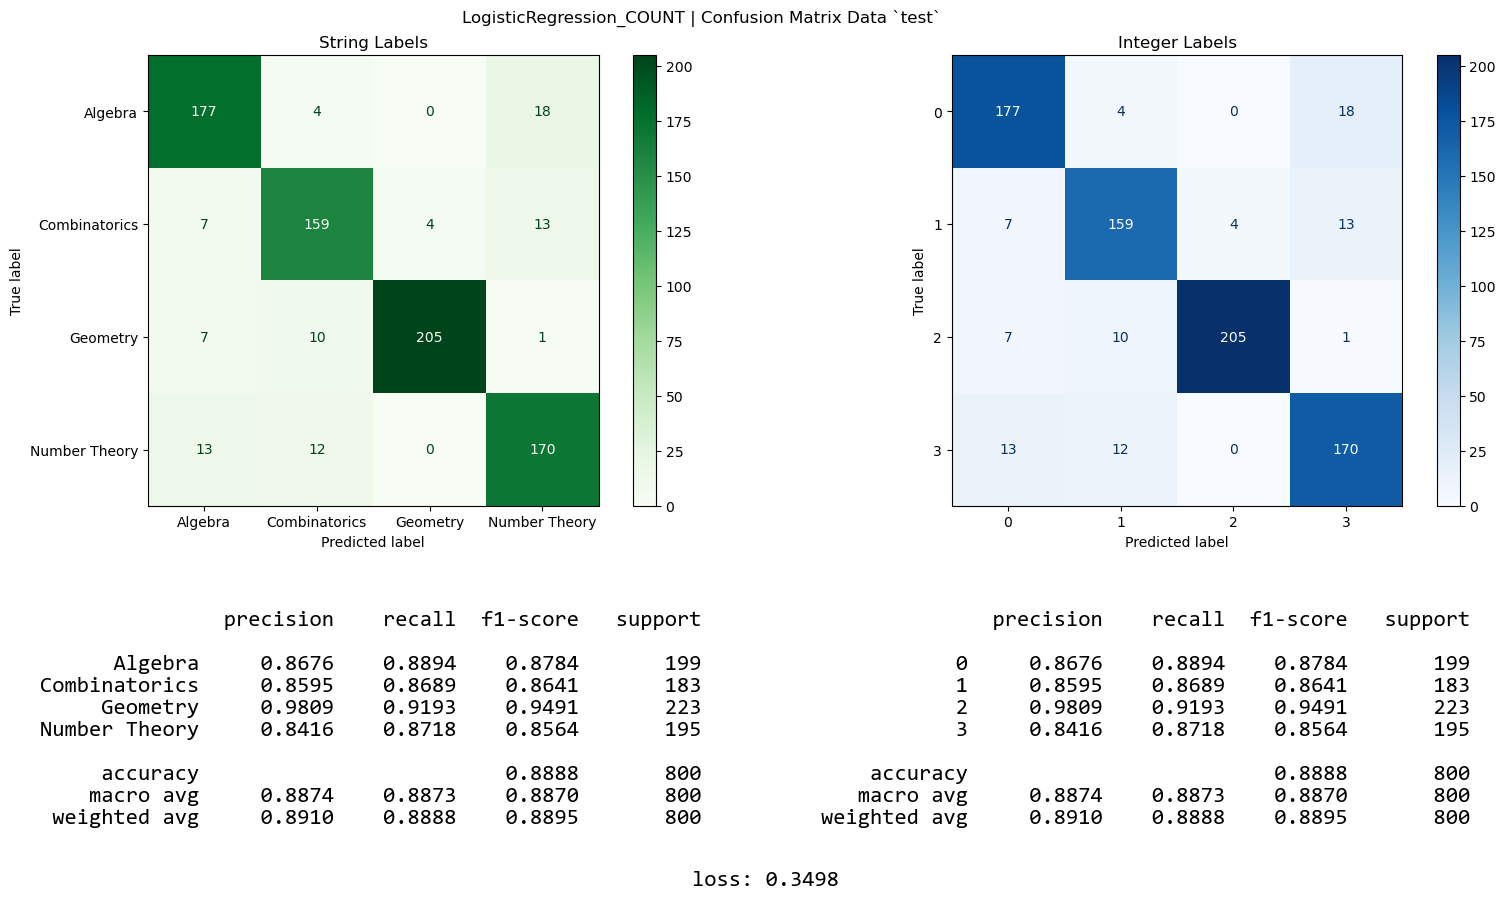

,index,text,actual,predicted,actual_int,predicted_int
63,190,Find all functions f: mathbb{R} rightarrow mat...,Algebra,Algebra,0,0
66,193,"Found all functions f: mathbb{R} to mathbb{R},...",Algebra,Algebra,0,0
346,277,A 9 times 12 rectangle is partitioned into uni...,Combinatorics,Combinatorics,1,1
533,392,A circle is called a separator for a set of fi...,Geometry,Combinatorics,2,1
490,576,"Let O, I, and omega be the circumcenter, the i...",Geometry,Geometry,2,2
456,600,Let P be a convex polygon. Prove that there ex...,Geometry,Geometry,2,2
696,771,"Find all pairs of positive integers (s, t), so...",Number Theory,Number Theory,3,3
667,792,Let left { {{a}_{n}} right }_{n geq 1} and lef...,Number Theory,Number Theory,3,3
621,745,Find all prime numbers p such that (x + y)^{19...,Number Theory,Number Theory,3,3
760,687,"Let (x_n), n=1,2, ldots be a sequence defined ...",Number Theory,Number Theory,3,3


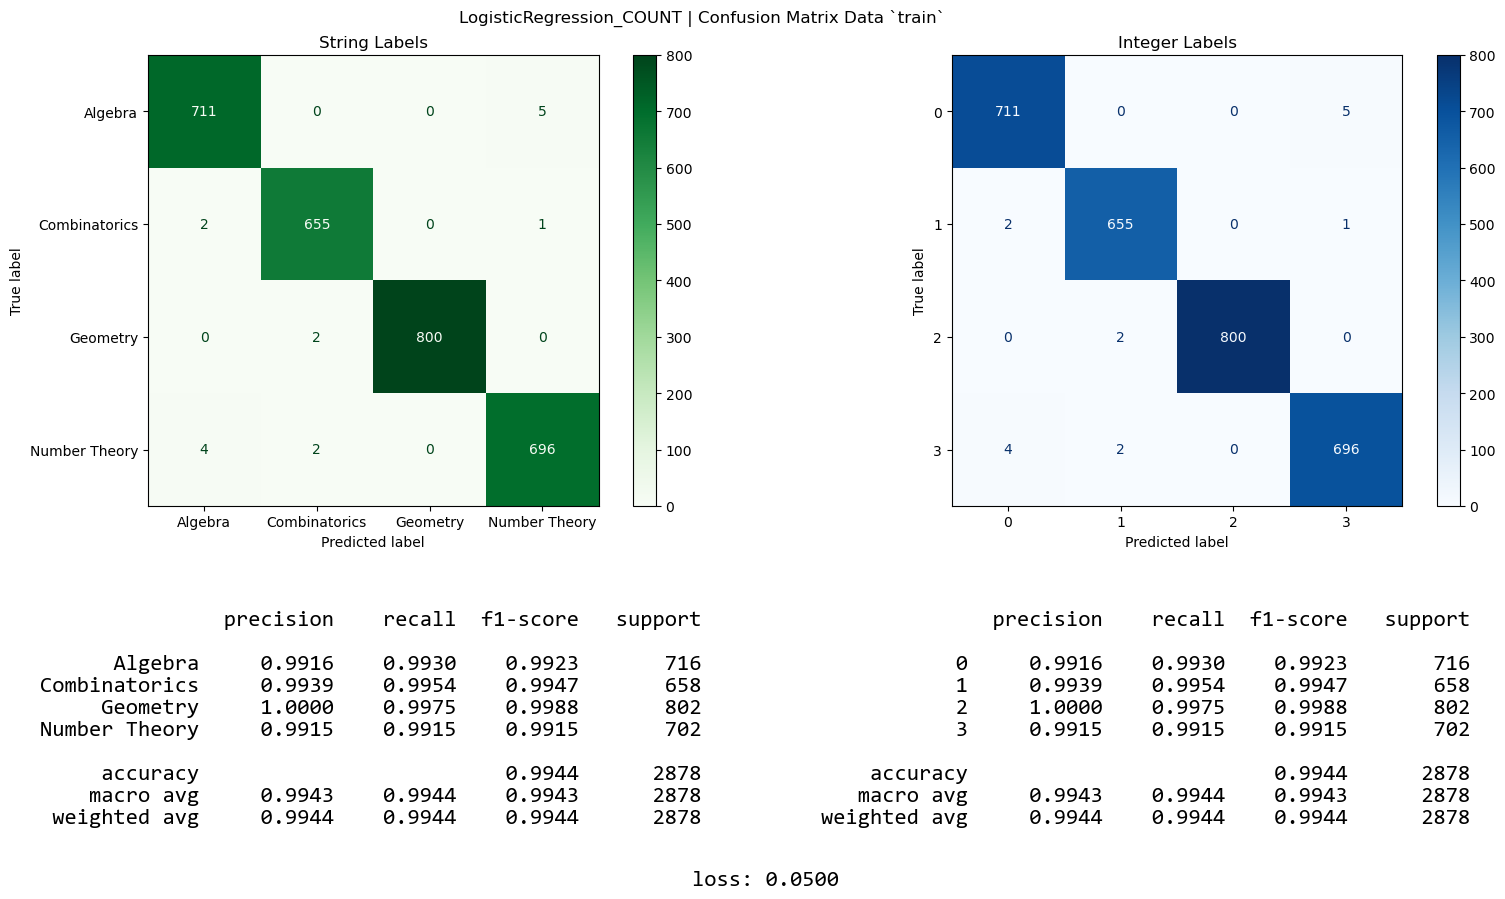

,index,text,actual,predicted,actual_int,predicted_int
471,20,"Prove that for all positive real numbers a,b,c...",Algebra,Algebra,0,0
1094,867,"Let E = {1, 2, dots , 16 } and let M be the co...",Combinatorics,Combinatorics,1,1
1255,1029,Two squares on an 8 times 8 chessboard are cal...,Combinatorics,Combinatorics,1,1
1128,795,"Let n geq 2, n in mathbb{N} and A_0 = (a_{01},...",Combinatorics,Combinatorics,1,1
945,1339,"On the board are written 2 , 3 , 5 ,... , 2003...",Combinatorics,Combinatorics,1,1
1453,1932,In a right-angled triangle ABC ( angle A = 90^...,Geometry,Geometry,2,2
1601,2080,Let ABCD be a rectangle of sides AB = 4 and BC...,Geometry,Geometry,2,2
1800,1499,Let ABC be an arbitrary triangle and M a point...,Geometry,Geometry,2,2
2376,2794,Find all functions g: mathbb{N} rightarrow mat...,Number Theory,Number Theory,3,3
2251,2671,"Let nu be an irrational positive number, and l...",Number Theory,Number Theory,3,3


Already exist --> 'saved_models/classification/LogisticRegression_COUNT' NOT CREATED
Saved: "saved_models/classification/LogisticRegression_COUNT/model.pkl"
Saved: "saved_models/classification/LogisticRegression_COUNT/vectorizer.pkl"


In [7]:
model = LogisticRegression()
md_name = "LogisticRegression"

# TFIDF
id_note = "17"
model, tfidf_test_result, _ = super_complete_compile_sklearn_model(id_note, model, TFIDF_vectorizer, train_texts, train_str_labels, train_int_labels, test_texts, test_str_labels, test_int_labels)
temp = f"{id_note},classification,{md_name},TfidfVectorizer,-,-,-,-,-,{tfidf_test_result['training_time']:.2f},"
temp+= f"{tfidf_test_result['loss']:.7f},{tfidf_test_result['accuracy']:.7f},{tfidf_test_result['macro avg']['precision']:.7f},"
temp+= f"{tfidf_test_result['macro avg']['recall']:.7f},{tfidf_test_result['macro avg']['f1-score']:.7f}"
append_training_result("Hasil training - Classification.csv", temp)

# Save model
directory = f"saved_models/classification/{md_name}_TFIDF"
create_folder(directory)
save_pkl(model, f"{directory}/model.pkl")
save_pkl(TFIDF_vectorizer, f"{directory}/vectorizer.pkl")


# COUNTVECTORIZER
id_note = "18"
model, count_test_result, _ = super_complete_compile_sklearn_model(id_note, model, COUNT_vectorizer, train_texts, train_str_labels, train_int_labels, test_texts, test_str_labels, test_int_labels)
temp = f"{id_note},classification,{md_name},CountVectorizer,-,-,-,-,-,{count_test_result['training_time']:.2f},"
temp+= f"{count_test_result['loss']:.7f},{count_test_result['accuracy']:.7f},{count_test_result['macro avg']['precision']:.7f},"
temp+= f"{count_test_result['macro avg']['recall']:.7f},{count_test_result['macro avg']['f1-score']:.7f}"
append_training_result("Hasil training - Classification.csv", temp)

# Save model
directory = f"saved_models/classification/{md_name}_COUNT"
create_folder(directory)
save_pkl(model, f"{directory}/model.pkl")
save_pkl(COUNT_vectorizer, f"{directory}/vectorizer.pkl")
